In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, GRU
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    gru_1 = GRU(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(gru_1)
    gru_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    gru_1_dropout = Dropout(0.3)(gru_1_LRelu)
    gru_2 = GRU(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(gru_1_dropout)
    batch_norm2 = tf.keras.layers.BatchNormalization()(gru_2)
    gru_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    gru_2_dropout = Dropout(0.3)(gru_2_LRelu)
    output_dense = Dense(n_features, activation=None)(gru_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "TSLA"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10  112.093689  114.125237  110.301147  112.810707   64.370766   
6    2000-01-11  112.691208  115.798279  111.496178  113.766731   64.916267   
7    2000-01-12  114.364243  116.634796  113.049713  114.244743   65.189072   
8    2000-01-13  114.663002  115.678780  110.659653  113.049713   64.507149   
9    2000-01-14  115.619026  117.889580  112.332695  114.364243   65.257248   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  118.432121  119.703636  118.298279  118.451241  106.144394   
5279 2020-12-24  119.502869  119.598473  118.747612  119.206497  106.821190   
5280 2020-12-28  119.598473  121.032501  118.986618  119.330788  106.932564   
5281 2020-12-29  119.837479  119.961761  117.820267  118.355644  106.058739   
5282 2020-12-30  118.355644  119.359467  118.193115  118.871895  106.521355   

        Volume          Ma  
5      8933363  109.285373  
6      8235472  109.667783  
7      7116775  110.994264  
8      8880226  111.663481  
9     11460604  112.476100  
...        ...         ...  
5278   2817819  119.302103  
5279   1842111  118.986615  
5280   3781499  118.822179  
5281   3647402  118.625238  
5282   3535794  118.703633  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru (GRU)                   (None, 5, 10)             570       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                             

Time for epoch 53 is 0.7400233745574951 sec Generator Loss: 1.068953514099121,  Discriminator_loss: 1.1907832622528076
Time for epoch 54 is 0.7374711036682129 sec Generator Loss: 1.0710495710372925,  Discriminator_loss: 1.1672089099884033
Time for epoch 55 is 0.773040771484375 sec Generator Loss: 1.0585289001464844,  Discriminator_loss: 1.180942177772522
Time for epoch 56 is 0.7581236362457275 sec Generator Loss: 1.0463505983352661,  Discriminator_loss: 1.195107340812683
Time for epoch 57 is 0.7476634979248047 sec Generator Loss: 1.0433210134506226,  Discriminator_loss: 1.192179799079895
Time for epoch 58 is 0.8106982707977295 sec Generator Loss: 1.035988688468933,  Discriminator_loss: 1.1968746185302734
Time for epoch 59 is 0.7739086151123047 sec Generator Loss: 1.0281853675842285,  Discriminator_loss: 1.2088085412979126
Time for epoch 60 is 0.847733736038208 sec Generator Loss: 1.0040806531906128,  Discriminator_loss: 1.22654390335083
Time for epoch 61 is 0.7598474025726318 sec Gener

Time for epoch 122 is 0.8181748390197754 sec Generator Loss: 0.8630523681640625,  Discriminator_loss: 1.3144534826278687
Time for epoch 123 is 0.8010342121124268 sec Generator Loss: 0.8686505556106567,  Discriminator_loss: 1.3127071857452393
Time for epoch 124 is 0.7940230369567871 sec Generator Loss: 0.8737444877624512,  Discriminator_loss: 1.3092679977416992
Time for epoch 125 is 0.7977237701416016 sec Generator Loss: 0.876234233379364,  Discriminator_loss: 1.3116146326065063
Time for epoch 126 is 0.798947811126709 sec Generator Loss: 0.8694071173667908,  Discriminator_loss: 1.3137402534484863
Time for epoch 127 is 0.8079731464385986 sec Generator Loss: 0.876390278339386,  Discriminator_loss: 1.305501937866211
Time for epoch 128 is 0.8114209175109863 sec Generator Loss: 0.8651926517486572,  Discriminator_loss: 1.3235552310943604
Time for epoch 129 is 0.794414758682251 sec Generator Loss: 0.8654845356941223,  Discriminator_loss: 1.3286640644073486
Time for epoch 130 is 0.7970690727233

Time for epoch 191 is 0.9675283432006836 sec Generator Loss: 0.8615902066230774,  Discriminator_loss: 1.3071082830429077
Time for epoch 192 is 0.935370922088623 sec Generator Loss: 0.8826237916946411,  Discriminator_loss: 1.2978988885879517
Time for epoch 193 is 0.9382355213165283 sec Generator Loss: 0.8543819785118103,  Discriminator_loss: 1.3166322708129883
Time for epoch 194 is 0.9308254718780518 sec Generator Loss: 0.857519268989563,  Discriminator_loss: 1.3172918558120728
Time for epoch 195 is 0.8864610195159912 sec Generator Loss: 0.8626382946968079,  Discriminator_loss: 1.3036988973617554
Time for epoch 196 is 0.8552114963531494 sec Generator Loss: 0.8586793541908264,  Discriminator_loss: 1.3129862546920776
Time for epoch 197 is 0.8520538806915283 sec Generator Loss: 0.8611962795257568,  Discriminator_loss: 1.3087937831878662
Time for epoch 198 is 0.797461986541748 sec Generator Loss: 0.8555691838264465,  Discriminator_loss: 1.3166248798370361
Time for epoch 199 is 0.79536724090

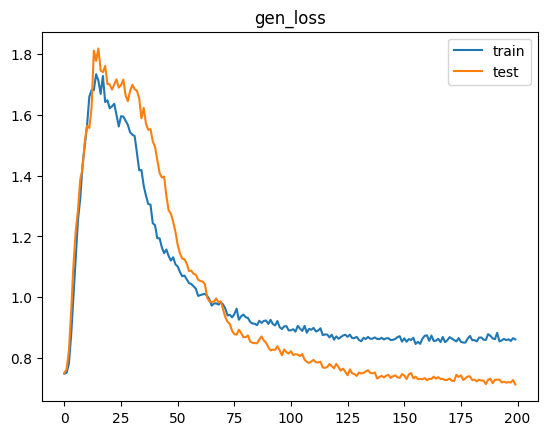

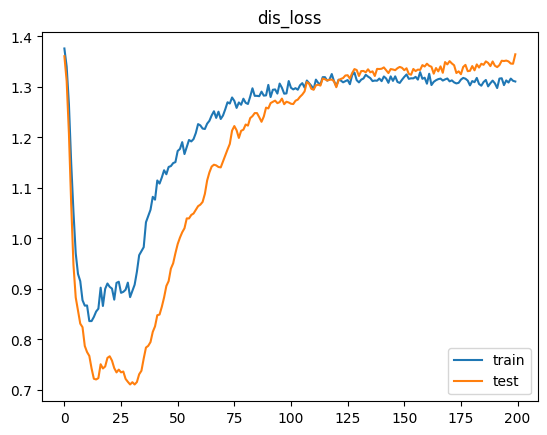

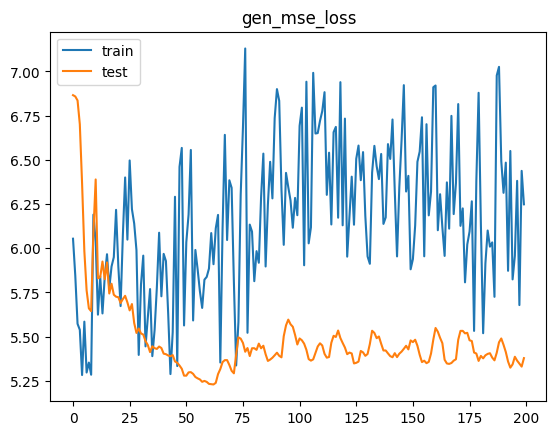

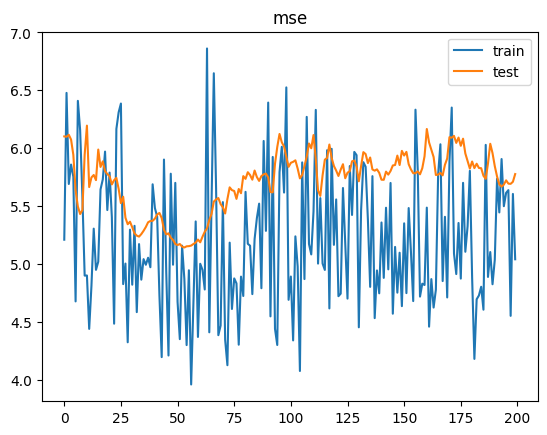

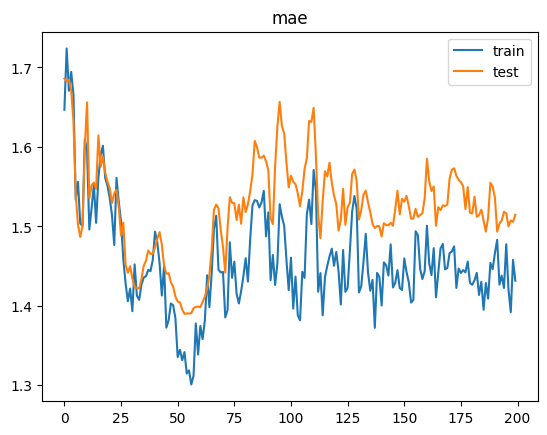

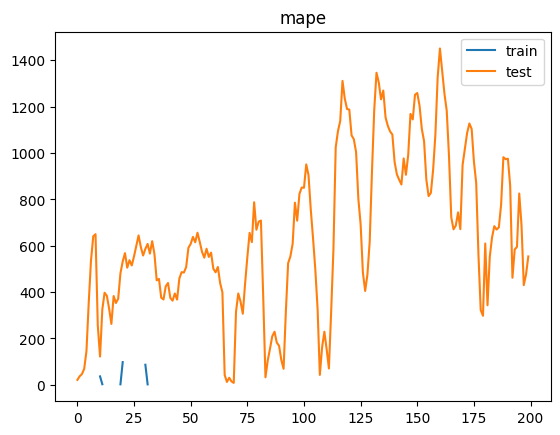

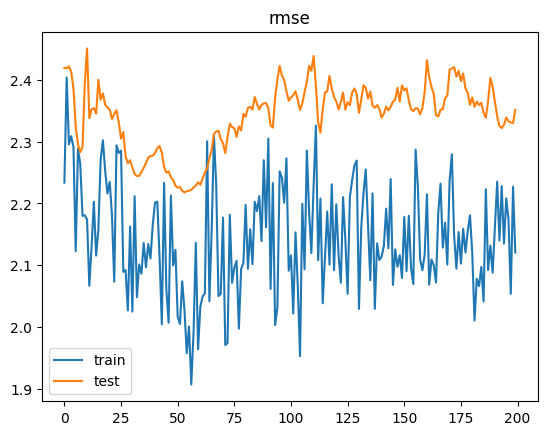

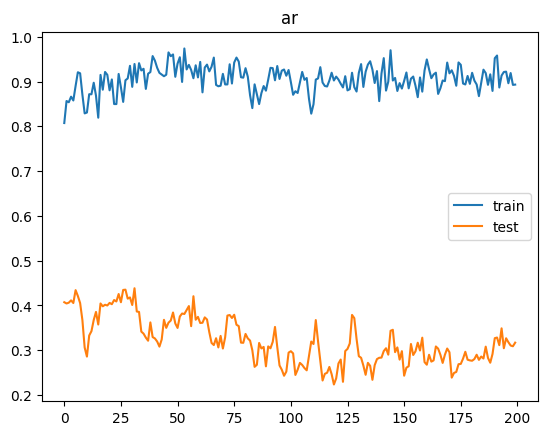

2/2 [==============================] - 0s 4ms/step


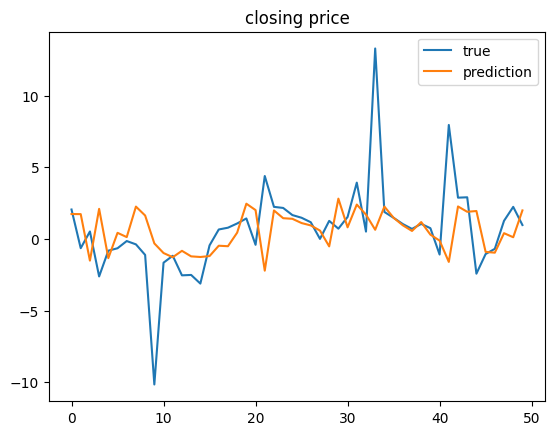

[MSE Baseline] train: 3.800774011940754  test: 4.988566607603537
Delta time with epochs = 200: 0:02:48.716698
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 gru_3 (GRU)   

Time for epoch 52 is 0.7874672412872314 sec Generator Loss: 0.9484093189239502,  Discriminator_loss: 1.2478923797607422
Time for epoch 53 is 0.8076877593994141 sec Generator Loss: 0.941127598285675,  Discriminator_loss: 1.2447242736816406
Time for epoch 54 is 0.7697155475616455 sec Generator Loss: 0.9259973764419556,  Discriminator_loss: 1.241705298423767
Time for epoch 55 is 0.7700073719024658 sec Generator Loss: 0.9261723160743713,  Discriminator_loss: 1.26642906665802
Time for epoch 56 is 0.8225407600402832 sec Generator Loss: 0.934455931186676,  Discriminator_loss: 1.258013367652893
Time for epoch 57 is 0.7824709415435791 sec Generator Loss: 0.9235438108444214,  Discriminator_loss: 1.2499524354934692
Time for epoch 58 is 0.7604975700378418 sec Generator Loss: 0.9257807731628418,  Discriminator_loss: 1.2590898275375366
Time for epoch 59 is 0.7387490272521973 sec Generator Loss: 0.9238182306289673,  Discriminator_loss: 1.2642580270767212
Time for epoch 60 is 0.742544412612915 sec Gen

Time for epoch 121 is 0.7659626007080078 sec Generator Loss: 0.8943087458610535,  Discriminator_loss: 1.2796343564987183
Time for epoch 122 is 0.7335076332092285 sec Generator Loss: 0.8822901248931885,  Discriminator_loss: 1.2943724393844604
Time for epoch 123 is 0.7590441703796387 sec Generator Loss: 0.9007515907287598,  Discriminator_loss: 1.2864171266555786
Time for epoch 124 is 0.7639658451080322 sec Generator Loss: 0.8893842697143555,  Discriminator_loss: 1.2975951433181763
Time for epoch 125 is 0.7608952522277832 sec Generator Loss: 0.8877627849578857,  Discriminator_loss: 1.2942296266555786
Time for epoch 126 is 0.748387336730957 sec Generator Loss: 0.8826384544372559,  Discriminator_loss: 1.2976467609405518
Time for epoch 127 is 0.7310523986816406 sec Generator Loss: 0.8885172605514526,  Discriminator_loss: 1.2953834533691406
Time for epoch 128 is 0.7258460521697998 sec Generator Loss: 0.8777678608894348,  Discriminator_loss: 1.294785737991333
Time for epoch 129 is 0.7273910045

Time for epoch 189 is 0.8773219585418701 sec Generator Loss: 0.8568298816680908,  Discriminator_loss: 1.3137112855911255
Time for epoch 190 is 0.8452818393707275 sec Generator Loss: 0.8631482720375061,  Discriminator_loss: 1.3128814697265625
Time for epoch 191 is 0.8825206756591797 sec Generator Loss: 0.8633681535720825,  Discriminator_loss: 1.3098413944244385
Time for epoch 192 is 0.8570690155029297 sec Generator Loss: 0.8508182764053345,  Discriminator_loss: 1.3173691034317017
Time for epoch 193 is 0.8555042743682861 sec Generator Loss: 0.8625928163528442,  Discriminator_loss: 1.3117012977600098
Time for epoch 194 is 0.8499288558959961 sec Generator Loss: 0.8627123832702637,  Discriminator_loss: 1.3141855001449585
Time for epoch 195 is 0.8578927516937256 sec Generator Loss: 0.8522313237190247,  Discriminator_loss: 1.3161524534225464
Time for epoch 196 is 0.8416621685028076 sec Generator Loss: 0.8677975535392761,  Discriminator_loss: 1.3029334545135498
Time for epoch 197 is 0.91924262

Time for epoch 257 is 0.8740873336791992 sec Generator Loss: 0.8720464110374451,  Discriminator_loss: 1.291579008102417
Time for epoch 258 is 0.8412344455718994 sec Generator Loss: 0.8793694376945496,  Discriminator_loss: 1.294763207435608
Time for epoch 259 is 0.8184328079223633 sec Generator Loss: 0.8916987776756287,  Discriminator_loss: 1.2928544282913208
Time for epoch 260 is 0.8295612335205078 sec Generator Loss: 0.8781304955482483,  Discriminator_loss: 1.298647403717041
Time for epoch 261 is 0.803443193435669 sec Generator Loss: 0.8835182189941406,  Discriminator_loss: 1.2926081418991089
Time for epoch 262 is 0.8045260906219482 sec Generator Loss: 0.8784782290458679,  Discriminator_loss: 1.3006095886230469
Time for epoch 263 is 0.8061325550079346 sec Generator Loss: 0.8767682313919067,  Discriminator_loss: 1.295861005783081
Time for epoch 264 is 0.8362689018249512 sec Generator Loss: 0.8680588603019714,  Discriminator_loss: 1.2983918190002441
Time for epoch 265 is 0.8736116886138

Time for epoch 325 is 0.8009703159332275 sec Generator Loss: 0.8707239627838135,  Discriminator_loss: 1.2991185188293457
Time for epoch 326 is 0.803006649017334 sec Generator Loss: 0.8729172348976135,  Discriminator_loss: 1.3021410703659058
Time for epoch 327 is 0.7969732284545898 sec Generator Loss: 0.866519570350647,  Discriminator_loss: 1.3023152351379395
Time for epoch 328 is 0.8162972927093506 sec Generator Loss: 0.8682374954223633,  Discriminator_loss: 1.3007172346115112
Time for epoch 329 is 0.8054075241088867 sec Generator Loss: 0.8618813753128052,  Discriminator_loss: 1.3069994449615479
Time for epoch 330 is 0.8181571960449219 sec Generator Loss: 0.8637961149215698,  Discriminator_loss: 1.3053619861602783
Time for epoch 331 is 0.811826229095459 sec Generator Loss: 0.8739902973175049,  Discriminator_loss: 1.2959282398223877
Time for epoch 332 is 0.8100183010101318 sec Generator Loss: 0.8841621279716492,  Discriminator_loss: 1.297189474105835
Time for epoch 333 is 0.806046962738

Time for epoch 394 is 0.8007721900939941 sec Generator Loss: 0.8915441632270813,  Discriminator_loss: 1.2901484966278076
Time for epoch 395 is 0.7701168060302734 sec Generator Loss: 0.8924891352653503,  Discriminator_loss: 1.2794179916381836
Time for epoch 396 is 0.7635495662689209 sec Generator Loss: 0.8912085294723511,  Discriminator_loss: 1.2907260656356812
Time for epoch 397 is 0.802515983581543 sec Generator Loss: 0.888254702091217,  Discriminator_loss: 1.2871718406677246
Time for epoch 398 is 0.7689914703369141 sec Generator Loss: 0.8946835398674011,  Discriminator_loss: 1.3003535270690918
Time for epoch 399 is 0.768568754196167 sec Generator Loss: 0.882002592086792,  Discriminator_loss: 1.2850353717803955
Time for epoch 400 is 0.7556769847869873 sec Generator Loss: 0.8850453495979309,  Discriminator_loss: 1.286609411239624
Time for epoch 401 is 0.7878527641296387 sec Generator Loss: 0.8966224789619446,  Discriminator_loss: 1.2836849689483643
Time for epoch 402 is 0.7926917076110

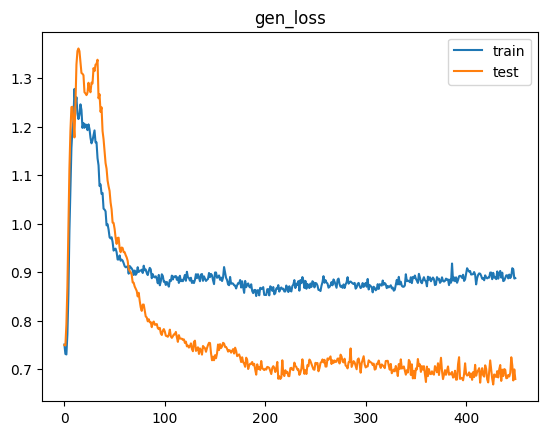

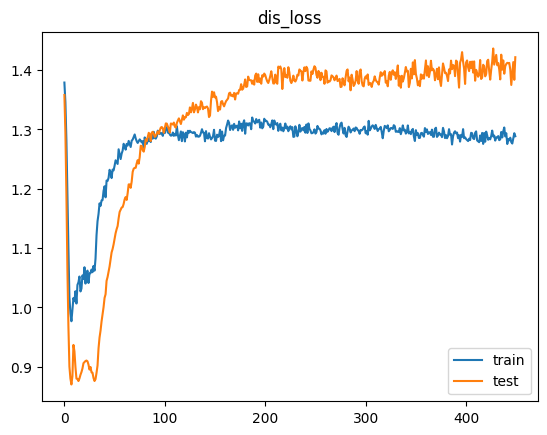

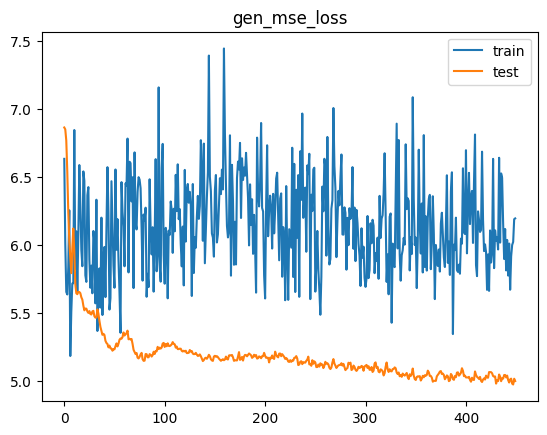

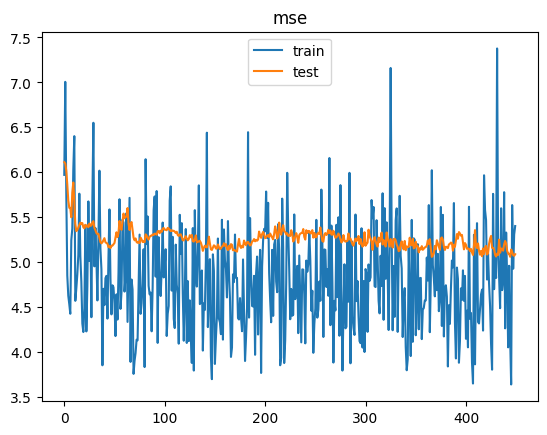

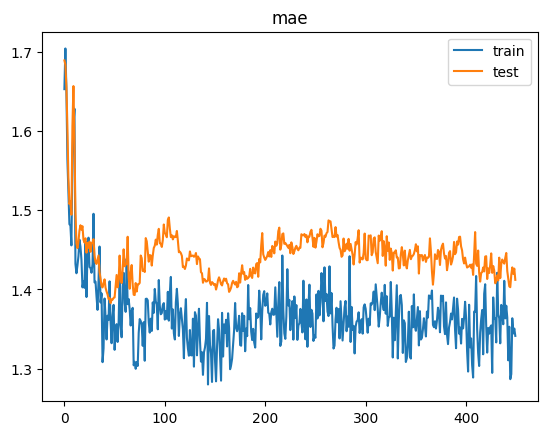

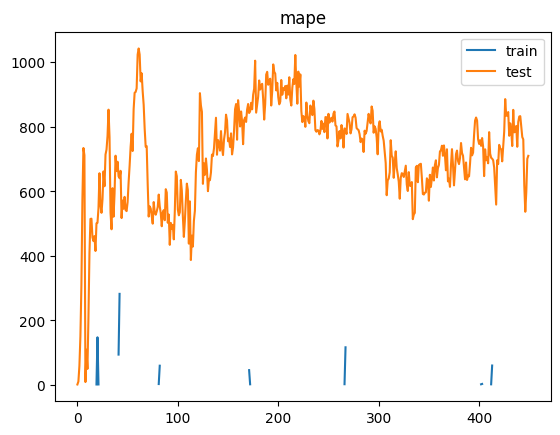

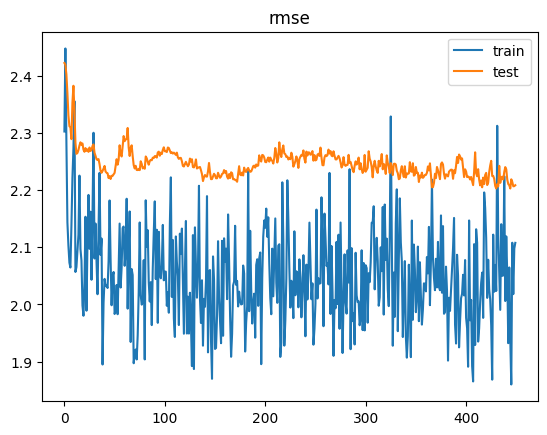

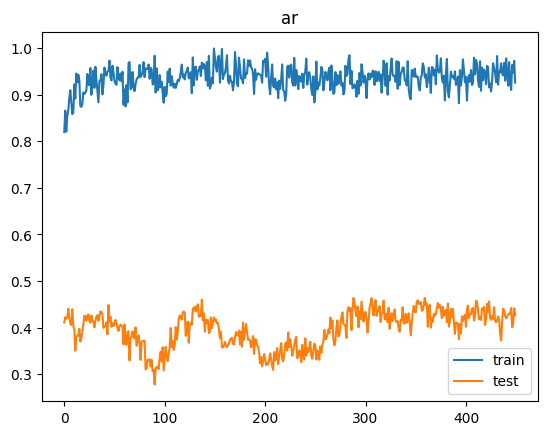

2/2 [==============================] - 0s 3ms/step


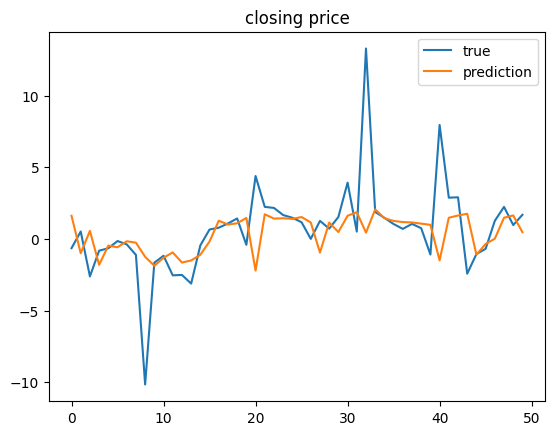

[MSE Baseline] train: 4.446885492853748  test: 5.002352560408067
Delta time with epochs = 450: 0:06:20.967687
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_4 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_5 (GRU)   

Time for epoch 52 is 0.746727466583252 sec Generator Loss: 1.0716800689697266,  Discriminator_loss: 1.1747339963912964
Time for epoch 53 is 0.7373402118682861 sec Generator Loss: 1.0428802967071533,  Discriminator_loss: 1.2026363611221313
Time for epoch 54 is 0.7402126789093018 sec Generator Loss: 1.032964825630188,  Discriminator_loss: 1.202280044555664
Time for epoch 55 is 0.7462325096130371 sec Generator Loss: 1.0245606899261475,  Discriminator_loss: 1.2006961107254028
Time for epoch 56 is 0.733004093170166 sec Generator Loss: 1.018065333366394,  Discriminator_loss: 1.2169556617736816
Time for epoch 57 is 0.7378058433532715 sec Generator Loss: 0.9988256692886353,  Discriminator_loss: 1.2223542928695679
Time for epoch 58 is 0.7367651462554932 sec Generator Loss: 0.9814195036888123,  Discriminator_loss: 1.2288557291030884
Time for epoch 59 is 0.7310531139373779 sec Generator Loss: 0.9920118451118469,  Discriminator_loss: 1.2330621480941772
Time for epoch 60 is 0.7390625476837158 sec G

Time for epoch 121 is 0.7259364128112793 sec Generator Loss: 0.9056963920593262,  Discriminator_loss: 1.2866582870483398
Time for epoch 122 is 0.7446751594543457 sec Generator Loss: 0.9068454504013062,  Discriminator_loss: 1.2809768915176392
Time for epoch 123 is 0.7333447933197021 sec Generator Loss: 0.9033145308494568,  Discriminator_loss: 1.2830619812011719
Time for epoch 124 is 0.7336986064910889 sec Generator Loss: 0.9008459448814392,  Discriminator_loss: 1.2850528955459595
Time for epoch 125 is 0.7325117588043213 sec Generator Loss: 0.8952653408050537,  Discriminator_loss: 1.2987656593322754
Time for epoch 126 is 0.7352490425109863 sec Generator Loss: 0.9075422286987305,  Discriminator_loss: 1.2854562997817993
Time for epoch 127 is 0.7522339820861816 sec Generator Loss: 0.906537652015686,  Discriminator_loss: 1.284181833267212
Time for epoch 128 is 0.7528243064880371 sec Generator Loss: 0.9193164110183716,  Discriminator_loss: 1.2817384004592896
Time for epoch 129 is 0.7759268283

Time for epoch 189 is 0.7354104518890381 sec Generator Loss: 0.9324114918708801,  Discriminator_loss: 1.2612669467926025
Time for epoch 190 is 0.7323098182678223 sec Generator Loss: 0.9096587300300598,  Discriminator_loss: 1.2805917263031006
Time for epoch 191 is 0.7409000396728516 sec Generator Loss: 0.91258305311203,  Discriminator_loss: 1.2786275148391724
Time for epoch 192 is 0.7369654178619385 sec Generator Loss: 0.9121471643447876,  Discriminator_loss: 1.2829163074493408
Time for epoch 193 is 0.7347729206085205 sec Generator Loss: 0.9090133905410767,  Discriminator_loss: 1.2831714153289795
Time for epoch 194 is 0.7317166328430176 sec Generator Loss: 0.9019455313682556,  Discriminator_loss: 1.2909373044967651
Time for epoch 195 is 0.7385029792785645 sec Generator Loss: 0.8992565870285034,  Discriminator_loss: 1.2911806106567383
Time for epoch 196 is 0.7321395874023438 sec Generator Loss: 0.9103009700775146,  Discriminator_loss: 1.2897833585739136
Time for epoch 197 is 0.7413091659

Time for epoch 257 is 0.8610212802886963 sec Generator Loss: 0.9021860957145691,  Discriminator_loss: 1.286752700805664
Time for epoch 258 is 0.8239295482635498 sec Generator Loss: 0.9067633152008057,  Discriminator_loss: 1.2776423692703247
Time for epoch 259 is 0.8306949138641357 sec Generator Loss: 0.8951029181480408,  Discriminator_loss: 1.2870235443115234
Time for epoch 260 is 0.7922573089599609 sec Generator Loss: 0.8886573314666748,  Discriminator_loss: 1.2914530038833618
Time for epoch 261 is 0.7774832248687744 sec Generator Loss: 0.8906351923942566,  Discriminator_loss: 1.287593960762024
Time for epoch 262 is 0.7731671333312988 sec Generator Loss: 0.9056881666183472,  Discriminator_loss: 1.2843419313430786
Time for epoch 263 is 0.7693359851837158 sec Generator Loss: 0.8943370580673218,  Discriminator_loss: 1.2902920246124268
Time for epoch 264 is 0.7764899730682373 sec Generator Loss: 0.8935357332229614,  Discriminator_loss: 1.294154167175293
Time for epoch 265 is 0.77539801597

Time for epoch 325 is 0.7809369564056396 sec Generator Loss: 0.8919835686683655,  Discriminator_loss: 1.2899456024169922
Time for epoch 326 is 0.784801721572876 sec Generator Loss: 0.888761043548584,  Discriminator_loss: 1.2923853397369385
Time for epoch 327 is 0.7687008380889893 sec Generator Loss: 0.896354079246521,  Discriminator_loss: 1.289913296699524
Time for epoch 328 is 0.7613868713378906 sec Generator Loss: 0.8832281827926636,  Discriminator_loss: 1.295899748802185
Time for epoch 329 is 0.7717881202697754 sec Generator Loss: 0.8921103477478027,  Discriminator_loss: 1.2899303436279297
Time for epoch 330 is 0.7720494270324707 sec Generator Loss: 0.8874887824058533,  Discriminator_loss: 1.2946354150772095
Time for epoch 331 is 0.7758979797363281 sec Generator Loss: 0.8914276361465454,  Discriminator_loss: 1.2834616899490356
Time for epoch 332 is 0.7777884006500244 sec Generator Loss: 0.8984500765800476,  Discriminator_loss: 1.2972050905227661
Time for epoch 333 is 0.7617628574371

Time for epoch 394 is 0.7681107521057129 sec Generator Loss: 0.8897238373756409,  Discriminator_loss: 1.2929426431655884
Time for epoch 395 is 0.857102632522583 sec Generator Loss: 0.9012397527694702,  Discriminator_loss: 1.2854081392288208
Time for epoch 396 is 0.836951732635498 sec Generator Loss: 0.8720625042915344,  Discriminator_loss: 1.305807113647461
Time for epoch 397 is 0.8289439678192139 sec Generator Loss: 0.8866604566574097,  Discriminator_loss: 1.2841098308563232
Time for epoch 398 is 0.80635666847229 sec Generator Loss: 0.8913611769676208,  Discriminator_loss: 1.2978436946868896
Time for epoch 399 is 0.7787308692932129 sec Generator Loss: 0.8890814185142517,  Discriminator_loss: 1.2881194353103638
Time for epoch 400 is 0.7691609859466553 sec Generator Loss: 0.8929259777069092,  Discriminator_loss: 1.2793200016021729
Time for epoch 401 is 0.7881171703338623 sec Generator Loss: 0.8891837000846863,  Discriminator_loss: 1.2936854362487793
Time for epoch 402 is 0.7722918987274

Time for epoch 463 is 1.3166146278381348 sec Generator Loss: 0.8863061666488647,  Discriminator_loss: 1.2925198078155518
Time for epoch 464 is 0.7745850086212158 sec Generator Loss: 0.8947761058807373,  Discriminator_loss: 1.2848762273788452
Time for epoch 465 is 0.7738535404205322 sec Generator Loss: 0.9000938534736633,  Discriminator_loss: 1.292725682258606
Time for epoch 466 is 0.781604528427124 sec Generator Loss: 0.9106636643409729,  Discriminator_loss: 1.2845299243927002
Time for epoch 467 is 0.812138557434082 sec Generator Loss: 0.8997085690498352,  Discriminator_loss: 1.2810388803482056
Time for epoch 468 is 0.7770857810974121 sec Generator Loss: 0.8907669186592102,  Discriminator_loss: 1.2976553440093994
Time for epoch 469 is 0.7739038467407227 sec Generator Loss: 0.8976258635520935,  Discriminator_loss: 1.2868543863296509
Time for epoch 470 is 0.7684683799743652 sec Generator Loss: 0.8903487324714661,  Discriminator_loss: 1.3015010356903076
Time for epoch 471 is 0.77075314521

Time for epoch 531 is 0.7804110050201416 sec Generator Loss: 0.9143538475036621,  Discriminator_loss: 1.2753159999847412
Time for epoch 532 is 0.7771255970001221 sec Generator Loss: 0.9023184776306152,  Discriminator_loss: 1.2833805084228516
Time for epoch 533 is 0.785048246383667 sec Generator Loss: 0.8924624919891357,  Discriminator_loss: 1.2855985164642334
Time for epoch 534 is 0.7787480354309082 sec Generator Loss: 0.9078807234764099,  Discriminator_loss: 1.2741680145263672
Time for epoch 535 is 0.7700486183166504 sec Generator Loss: 0.9117743372917175,  Discriminator_loss: 1.2784301042556763
Time for epoch 536 is 0.7837896347045898 sec Generator Loss: 0.9021052122116089,  Discriminator_loss: 1.2783697843551636
Time for epoch 537 is 0.7720992565155029 sec Generator Loss: 0.9065853953361511,  Discriminator_loss: 1.2908216714859009
Time for epoch 538 is 0.7735364437103271 sec Generator Loss: 0.9108309745788574,  Discriminator_loss: 1.2841929197311401
Time for epoch 539 is 0.792546272

Time for epoch 599 is 0.8055448532104492 sec Generator Loss: 0.9178419709205627,  Discriminator_loss: 1.2805936336517334
Time for epoch 600 is 0.8306107521057129 sec Generator Loss: 0.9036306142807007,  Discriminator_loss: 1.2826341390609741
Time for epoch 601 is 0.804732084274292 sec Generator Loss: 0.9065589904785156,  Discriminator_loss: 1.2772938013076782
Time for epoch 602 is 0.7826628684997559 sec Generator Loss: 0.9267200827598572,  Discriminator_loss: 1.2776870727539062
Time for epoch 603 is 0.7800281047821045 sec Generator Loss: 0.91246098279953,  Discriminator_loss: 1.2843210697174072
Time for epoch 604 is 0.7750334739685059 sec Generator Loss: 0.9043219089508057,  Discriminator_loss: 1.285821557044983
Time for epoch 605 is 0.78102707862854 sec Generator Loss: 0.9124320149421692,  Discriminator_loss: 1.2802073955535889
Time for epoch 606 is 0.7952351570129395 sec Generator Loss: 0.919879674911499,  Discriminator_loss: 1.2735704183578491
Time for epoch 607 is 0.791024446487426

Time for epoch 667 is 0.7757763862609863 sec Generator Loss: 0.9122819900512695,  Discriminator_loss: 1.2731595039367676
Time for epoch 668 is 0.7874414920806885 sec Generator Loss: 0.9304758906364441,  Discriminator_loss: 1.2749402523040771
Time for epoch 669 is 0.7976922988891602 sec Generator Loss: 0.9039210081100464,  Discriminator_loss: 1.2826088666915894
Time for epoch 670 is 0.7795958518981934 sec Generator Loss: 0.9311522245407104,  Discriminator_loss: 1.2662523984909058
Time for epoch 671 is 0.7764365673065186 sec Generator Loss: 0.9193113446235657,  Discriminator_loss: 1.2741122245788574
Time for epoch 672 is 0.7861232757568359 sec Generator Loss: 0.9297428727149963,  Discriminator_loss: 1.268971562385559
Time for epoch 673 is 0.7754921913146973 sec Generator Loss: 0.921419620513916,  Discriminator_loss: 1.273863434791565
Time for epoch 674 is 0.855135440826416 sec Generator Loss: 0.9382094144821167,  Discriminator_loss: 1.2611714601516724
Time for epoch 675 is 0.824017524719

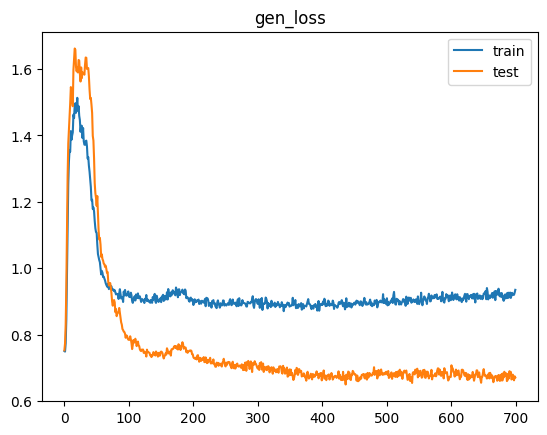

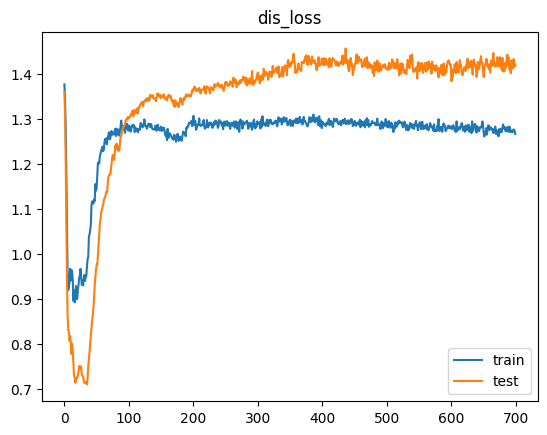

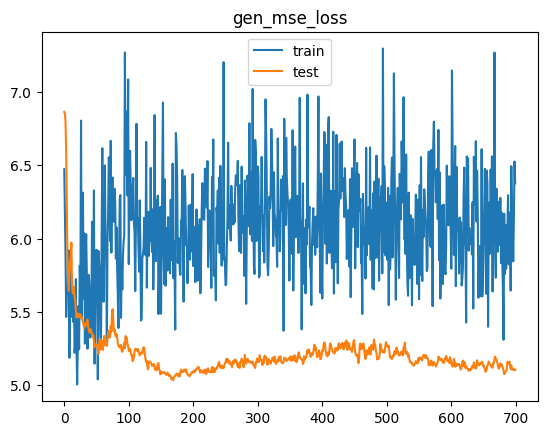

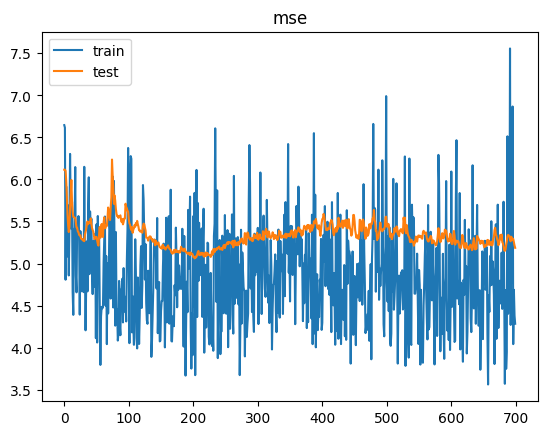

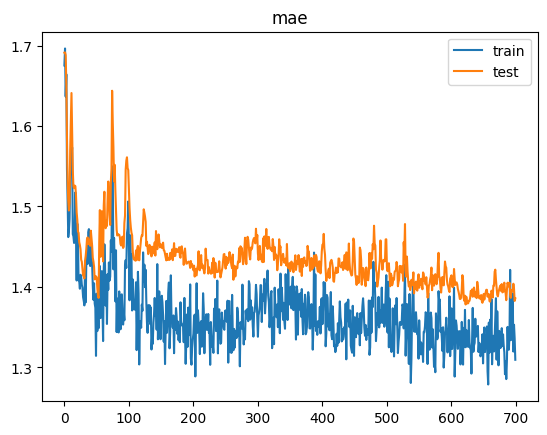

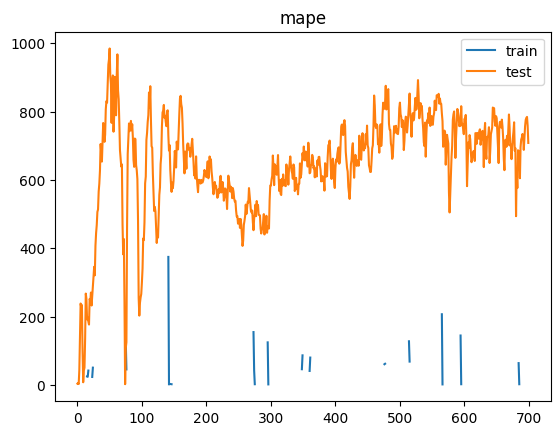

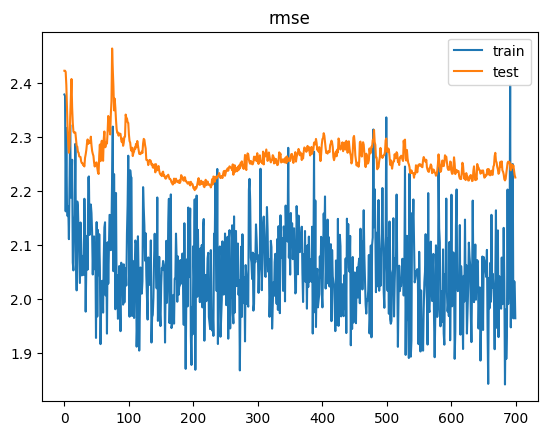

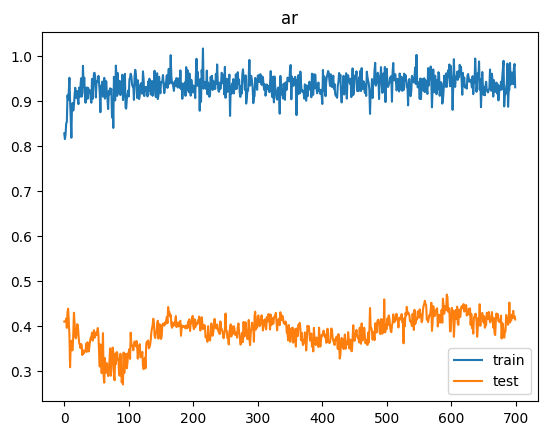

2/2 [==============================] - 0s 3ms/step


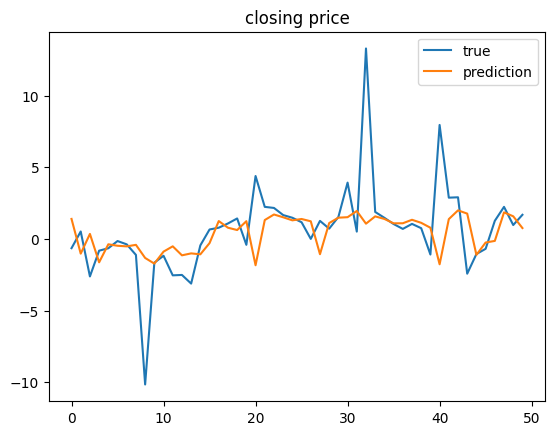

[MSE Baseline] train: 5.7242568152470925  test: 5.002352560408067
Delta time with epochs = 700: 0:09:18.329910


In [20]:
for epochs in [200, 450, 700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_6 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_7 (GRU)                 (None, 10)                660       
                                                           

Time for epoch 53 is 0.7824523448944092 sec Generator Loss: 1.0270320177078247,  Discriminator_loss: 1.205376386642456
Time for epoch 54 is 0.7780604362487793 sec Generator Loss: 1.0208635330200195,  Discriminator_loss: 1.2005852460861206
Time for epoch 55 is 0.8025939464569092 sec Generator Loss: 1.0094331502914429,  Discriminator_loss: 1.196825623512268
Time for epoch 56 is 0.7828471660614014 sec Generator Loss: 1.0177148580551147,  Discriminator_loss: 1.1927944421768188
Time for epoch 57 is 0.7817230224609375 sec Generator Loss: 1.0024402141571045,  Discriminator_loss: 1.2150121927261353
Time for epoch 58 is 0.8015451431274414 sec Generator Loss: 1.0061242580413818,  Discriminator_loss: 1.2046347856521606
Time for epoch 59 is 0.7912163734436035 sec Generator Loss: 1.0373586416244507,  Discriminator_loss: 1.1946368217468262
Time for epoch 60 is 0.7924966812133789 sec Generator Loss: 1.0176658630371094,  Discriminator_loss: 1.1987719535827637
Time for epoch 61 is 0.7810623645782471 se

Time for epoch 122 is 0.8146347999572754 sec Generator Loss: 0.8896133303642273,  Discriminator_loss: 1.2904807329177856
Time for epoch 123 is 0.7884418964385986 sec Generator Loss: 0.9007054567337036,  Discriminator_loss: 1.2877675294876099
Time for epoch 124 is 0.7829709053039551 sec Generator Loss: 0.9044513702392578,  Discriminator_loss: 1.2867636680603027
Time for epoch 125 is 0.7858188152313232 sec Generator Loss: 0.9142972230911255,  Discriminator_loss: 1.2771304845809937
Time for epoch 126 is 0.7740652561187744 sec Generator Loss: 0.9007524847984314,  Discriminator_loss: 1.282973051071167
Time for epoch 127 is 0.7988228797912598 sec Generator Loss: 0.9082484245300293,  Discriminator_loss: 1.2938356399536133
Time for epoch 128 is 0.7963821887969971 sec Generator Loss: 0.886585533618927,  Discriminator_loss: 1.2958568334579468
Time for epoch 129 is 0.7848799228668213 sec Generator Loss: 0.9032658934593201,  Discriminator_loss: 1.2821019887924194
Time for epoch 130 is 0.7783648967

Time for epoch 190 is 0.7801635265350342 sec Generator Loss: 0.8870182037353516,  Discriminator_loss: 1.2985045909881592
Time for epoch 191 is 0.8062975406646729 sec Generator Loss: 0.8651911616325378,  Discriminator_loss: 1.3052887916564941
Time for epoch 192 is 0.8158948421478271 sec Generator Loss: 0.8879572749137878,  Discriminator_loss: 1.291861891746521
Time for epoch 193 is 0.8311152458190918 sec Generator Loss: 0.884977400302887,  Discriminator_loss: 1.2958488464355469
Time for epoch 194 is 0.8263833522796631 sec Generator Loss: 0.8842694163322449,  Discriminator_loss: 1.2993782758712769
Time for epoch 195 is 0.8012752532958984 sec Generator Loss: 0.8970460295677185,  Discriminator_loss: 1.286670446395874
Time for epoch 196 is 0.7646067142486572 sec Generator Loss: 0.8635703325271606,  Discriminator_loss: 1.3085436820983887
Time for epoch 197 is 0.747534990310669 sec Generator Loss: 0.8759297132492065,  Discriminator_loss: 1.296024203300476
Time for epoch 198 is 0.7515661716461

Time for epoch 258 is 0.7461936473846436 sec Generator Loss: 0.8789592981338501,  Discriminator_loss: 1.3014272451400757
Time for epoch 259 is 0.7415409088134766 sec Generator Loss: 0.8676425218582153,  Discriminator_loss: 1.3067502975463867
Time for epoch 260 is 0.7468512058258057 sec Generator Loss: 0.8803758025169373,  Discriminator_loss: 1.300165057182312
Time for epoch 261 is 0.7463076114654541 sec Generator Loss: 0.8799959421157837,  Discriminator_loss: 1.299873948097229
Time for epoch 262 is 0.7555439472198486 sec Generator Loss: 0.8799121975898743,  Discriminator_loss: 1.3012992143630981
Time for epoch 263 is 0.7395038604736328 sec Generator Loss: 0.8757250308990479,  Discriminator_loss: 1.301617980003357
Time for epoch 264 is 0.7508611679077148 sec Generator Loss: 0.8813230395317078,  Discriminator_loss: 1.2947696447372437
Time for epoch 265 is 0.7411508560180664 sec Generator Loss: 0.8763650059700012,  Discriminator_loss: 1.296127438545227
Time for epoch 266 is 0.750266075134

Time for epoch 326 is 0.7415242195129395 sec Generator Loss: 0.8802987337112427,  Discriminator_loss: 1.2933388948440552
Time for epoch 327 is 0.7825794219970703 sec Generator Loss: 0.8817377090454102,  Discriminator_loss: 1.2915315628051758
Time for epoch 328 is 0.7517154216766357 sec Generator Loss: 0.8894866704940796,  Discriminator_loss: 1.295513391494751
Time for epoch 329 is 0.752021074295044 sec Generator Loss: 0.8778790235519409,  Discriminator_loss: 1.3016536235809326
Time for epoch 330 is 0.7580521106719971 sec Generator Loss: 0.884104311466217,  Discriminator_loss: 1.3028770685195923
Time for epoch 331 is 0.7475581169128418 sec Generator Loss: 0.8885706067085266,  Discriminator_loss: 1.285919189453125
Time for epoch 332 is 0.751715898513794 sec Generator Loss: 0.8868783116340637,  Discriminator_loss: 1.3024623394012451
Time for epoch 333 is 0.7443962097167969 sec Generator Loss: 0.899010956287384,  Discriminator_loss: 1.285807728767395
Time for epoch 334 is 0.748896121978759

Time for epoch 395 is 0.757282018661499 sec Generator Loss: 0.8842301368713379,  Discriminator_loss: 1.2874325513839722
Time for epoch 396 is 0.7645325660705566 sec Generator Loss: 0.8690959811210632,  Discriminator_loss: 1.2965927124023438
Time for epoch 397 is 0.7598018646240234 sec Generator Loss: 0.8831977248191833,  Discriminator_loss: 1.2902812957763672
Time for epoch 398 is 0.7542800903320312 sec Generator Loss: 0.8979426622390747,  Discriminator_loss: 1.2960201501846313
Time for epoch 399 is 0.7570593357086182 sec Generator Loss: 0.898185670375824,  Discriminator_loss: 1.2865779399871826
Time for epoch 400 is 0.7482008934020996 sec Generator Loss: 0.8760136365890503,  Discriminator_loss: 1.2990684509277344
Time for epoch 401 is 0.7412872314453125 sec Generator Loss: 0.8840808868408203,  Discriminator_loss: 1.2932682037353516
Time for epoch 402 is 0.7415745258331299 sec Generator Loss: 0.8877052068710327,  Discriminator_loss: 1.2904232740402222
Time for epoch 403 is 0.7573132514

Time for epoch 463 is 0.7615659236907959 sec Generator Loss: 0.8922738432884216,  Discriminator_loss: 1.2899997234344482
Time for epoch 464 is 0.7504496574401855 sec Generator Loss: 0.884910523891449,  Discriminator_loss: 1.2886418104171753
Time for epoch 465 is 0.748882532119751 sec Generator Loss: 0.8822341561317444,  Discriminator_loss: 1.2981396913528442
Time for epoch 466 is 0.7487943172454834 sec Generator Loss: 0.8991537690162659,  Discriminator_loss: 1.2881850004196167
Time for epoch 467 is 0.757413387298584 sec Generator Loss: 0.8998031616210938,  Discriminator_loss: 1.289922833442688
Time for epoch 468 is 0.7495982646942139 sec Generator Loss: 0.8822807669639587,  Discriminator_loss: 1.2983381748199463
Time for epoch 469 is 0.7442123889923096 sec Generator Loss: 0.8863041400909424,  Discriminator_loss: 1.2982020378112793
Time for epoch 470 is 0.7535097599029541 sec Generator Loss: 0.8940068483352661,  Discriminator_loss: 1.3001092672348022
Time for epoch 471 is 0.745506286621

Time for epoch 532 is 0.7442126274108887 sec Generator Loss: 0.8800061345100403,  Discriminator_loss: 1.3077301979064941
Time for epoch 533 is 0.7544143199920654 sec Generator Loss: 0.8752232789993286,  Discriminator_loss: 1.3003082275390625
Time for epoch 534 is 0.7540767192840576 sec Generator Loss: 0.8642022013664246,  Discriminator_loss: 1.3101011514663696
Time for epoch 535 is 0.7558927536010742 sec Generator Loss: 0.8873233795166016,  Discriminator_loss: 1.2994757890701294
Time for epoch 536 is 0.7525050640106201 sec Generator Loss: 0.8813586235046387,  Discriminator_loss: 1.295449137687683
Time for epoch 537 is 0.7552385330200195 sec Generator Loss: 0.8747761845588684,  Discriminator_loss: 1.3024522066116333
Time for epoch 538 is 0.7500452995300293 sec Generator Loss: 0.8677541017532349,  Discriminator_loss: 1.3132779598236084
Time for epoch 539 is 0.762131929397583 sec Generator Loss: 0.8619005680084229,  Discriminator_loss: 1.3080400228500366
Time for epoch 540 is 0.7541377544

Time for epoch 600 is 0.807563304901123 sec Generator Loss: 0.8838791251182556,  Discriminator_loss: 1.2947275638580322
Time for epoch 601 is 0.8382618427276611 sec Generator Loss: 0.891716718673706,  Discriminator_loss: 1.2885048389434814
Time for epoch 602 is 0.8167588710784912 sec Generator Loss: 0.8906338810920715,  Discriminator_loss: 1.3012807369232178
Time for epoch 603 is 0.8059325218200684 sec Generator Loss: 0.889670193195343,  Discriminator_loss: 1.296830177307129
Time for epoch 604 is 0.7967383861541748 sec Generator Loss: 0.8846362829208374,  Discriminator_loss: 1.3025438785552979
Time for epoch 605 is 0.7779998779296875 sec Generator Loss: 0.8805860280990601,  Discriminator_loss: 1.2971720695495605
Time for epoch 606 is 0.7949438095092773 sec Generator Loss: 0.8709861636161804,  Discriminator_loss: 1.304636001586914
Time for epoch 607 is 0.7775290012359619 sec Generator Loss: 0.8866251707077026,  Discriminator_loss: 1.295103907585144
Time for epoch 608 is 0.85380101203918

Time for epoch 668 is 0.761082649230957 sec Generator Loss: 0.8975998163223267,  Discriminator_loss: 1.2911282777786255
Time for epoch 669 is 0.7739839553833008 sec Generator Loss: 0.8854361772537231,  Discriminator_loss: 1.301943302154541
Time for epoch 670 is 0.7573268413543701 sec Generator Loss: 0.9038916826248169,  Discriminator_loss: 1.286063551902771
Time for epoch 671 is 0.7515566349029541 sec Generator Loss: 0.8826506733894348,  Discriminator_loss: 1.3120574951171875
Time for epoch 672 is 0.7540271282196045 sec Generator Loss: 0.8761693835258484,  Discriminator_loss: 1.3172032833099365
Time for epoch 673 is 0.7549400329589844 sec Generator Loss: 0.8834169507026672,  Discriminator_loss: 1.291218876838684
Time for epoch 674 is 0.7640001773834229 sec Generator Loss: 0.8950801491737366,  Discriminator_loss: 1.2885522842407227
Time for epoch 675 is 0.7549967765808105 sec Generator Loss: 0.8925580382347107,  Discriminator_loss: 1.297521710395813
Time for epoch 676 is 0.7594647407531

Time for epoch 737 is 0.8561625480651855 sec Generator Loss: 0.8849489092826843,  Discriminator_loss: 1.2953354120254517
Time for epoch 738 is 0.9701235294342041 sec Generator Loss: 0.8996714949607849,  Discriminator_loss: 1.2888911962509155
Time for epoch 739 is 1.0475151538848877 sec Generator Loss: 0.8941887021064758,  Discriminator_loss: 1.2954994440078735
Time for epoch 740 is 0.947615385055542 sec Generator Loss: 0.8785023093223572,  Discriminator_loss: 1.305753469467163
Time for epoch 741 is 0.9280345439910889 sec Generator Loss: 0.8811238408088684,  Discriminator_loss: 1.3029625415802002
Time for epoch 742 is 0.8416433334350586 sec Generator Loss: 0.8813269734382629,  Discriminator_loss: 1.2966976165771484
Time for epoch 743 is 0.8048937320709229 sec Generator Loss: 0.9003193974494934,  Discriminator_loss: 1.2895759344100952
Time for epoch 744 is 0.8083934783935547 sec Generator Loss: 0.8884097933769226,  Discriminator_loss: 1.299532175064087
Time for epoch 745 is 0.79649329185

Time for epoch 805 is 0.8917522430419922 sec Generator Loss: 0.8959947228431702,  Discriminator_loss: 1.3016728162765503
Time for epoch 806 is 0.9109804630279541 sec Generator Loss: 0.8933575749397278,  Discriminator_loss: 1.2841957807540894
Time for epoch 807 is 0.9048407077789307 sec Generator Loss: 0.8952951431274414,  Discriminator_loss: 1.293944239616394
Time for epoch 808 is 0.8852865695953369 sec Generator Loss: 0.9035672545433044,  Discriminator_loss: 1.2950842380523682
Time for epoch 809 is 0.8791749477386475 sec Generator Loss: 0.9008500576019287,  Discriminator_loss: 1.2908800840377808
Time for epoch 810 is 0.8500802516937256 sec Generator Loss: 0.8993529677391052,  Discriminator_loss: 1.2901309728622437
Time for epoch 811 is 0.8439695835113525 sec Generator Loss: 0.8982808589935303,  Discriminator_loss: 1.2803938388824463
Time for epoch 812 is 0.8510861396789551 sec Generator Loss: 0.89846271276474,  Discriminator_loss: 1.2942252159118652
Time for epoch 813 is 0.85687804222

Time for epoch 874 is 0.8737349510192871 sec Generator Loss: 0.8998645544052124,  Discriminator_loss: 1.2968122959136963
Time for epoch 875 is 1.129974126815796 sec Generator Loss: 0.8900588154792786,  Discriminator_loss: 1.2929449081420898
Time for epoch 876 is 1.0278377532958984 sec Generator Loss: 0.8971230387687683,  Discriminator_loss: 1.2976289987564087
Time for epoch 877 is 0.9924261569976807 sec Generator Loss: 0.8933287262916565,  Discriminator_loss: 1.289565920829773
Time for epoch 878 is 0.9218056201934814 sec Generator Loss: 0.906038224697113,  Discriminator_loss: 1.2887284755706787
Time for epoch 879 is 0.9457933902740479 sec Generator Loss: 0.9015918374061584,  Discriminator_loss: 1.2995226383209229
Time for epoch 880 is 0.9015417098999023 sec Generator Loss: 0.8947782516479492,  Discriminator_loss: 1.2987695932388306
Time for epoch 881 is 0.9095282554626465 sec Generator Loss: 0.8816958069801331,  Discriminator_loss: 1.2982250452041626
Time for epoch 882 is 0.94275236129

Time for epoch 942 is 0.886122465133667 sec Generator Loss: 0.9109281301498413,  Discriminator_loss: 1.284853458404541
Time for epoch 943 is 0.8804440498352051 sec Generator Loss: 0.9105419516563416,  Discriminator_loss: 1.2873891592025757
Time for epoch 944 is 0.8435409069061279 sec Generator Loss: 0.896517813205719,  Discriminator_loss: 1.291896104812622
Time for epoch 945 is 0.8047795295715332 sec Generator Loss: 0.9022924900054932,  Discriminator_loss: 1.293501377105713
Time for epoch 946 is 0.8031997680664062 sec Generator Loss: 0.9098786115646362,  Discriminator_loss: 1.290198802947998
Time for epoch 947 is 0.8739666938781738 sec Generator Loss: 0.8986903429031372,  Discriminator_loss: 1.2903841733932495
Time for epoch 948 is 0.8785262107849121 sec Generator Loss: 0.9018744230270386,  Discriminator_loss: 1.2834820747375488
Time for epoch 949 is 0.8925340175628662 sec Generator Loss: 0.8942185640335083,  Discriminator_loss: 1.292712688446045
Time for epoch 950 is 0.930701017379760

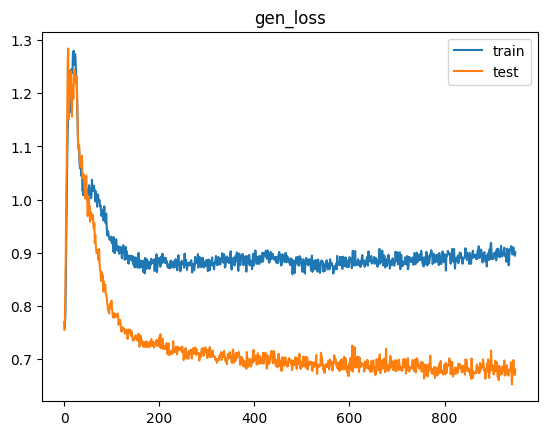

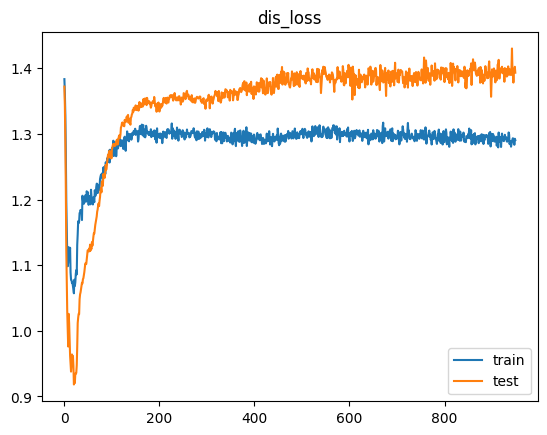

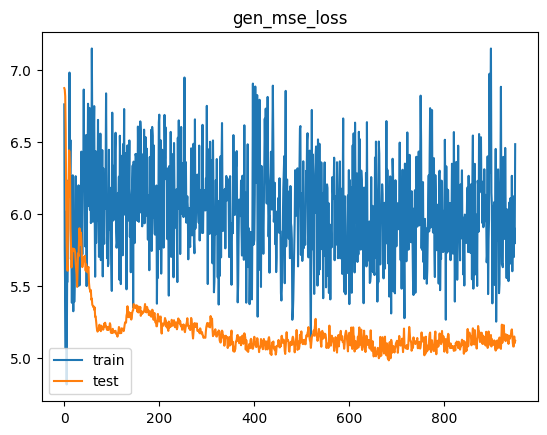

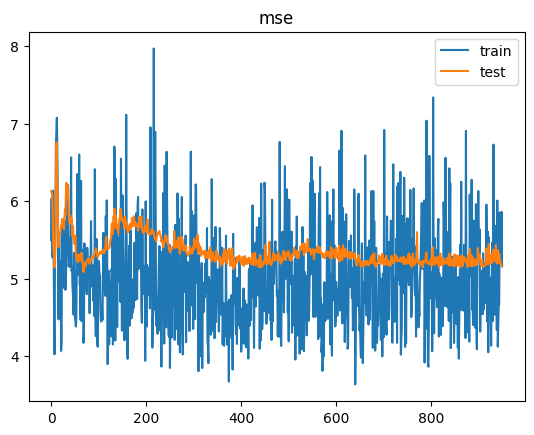

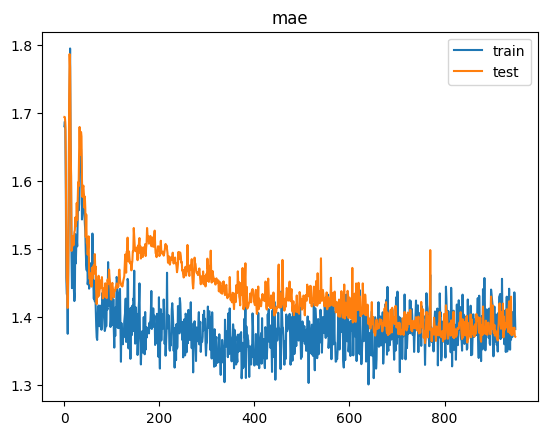

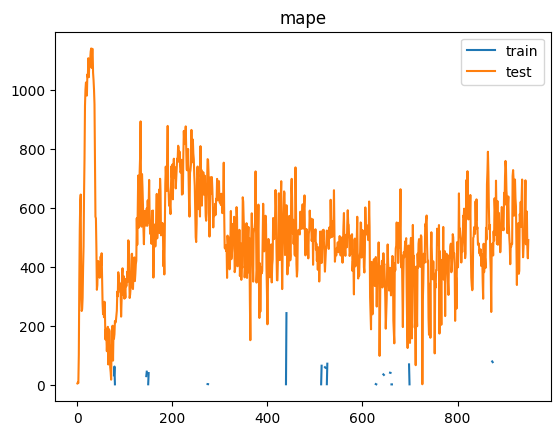

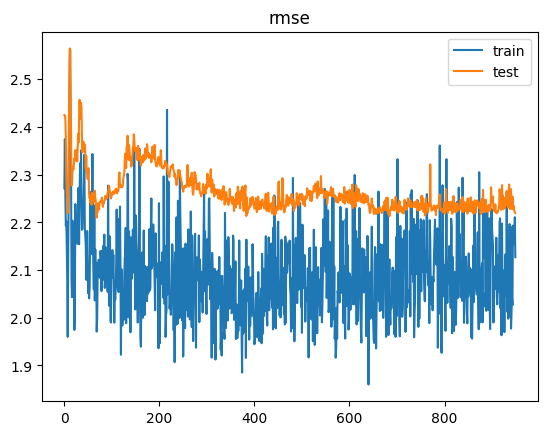

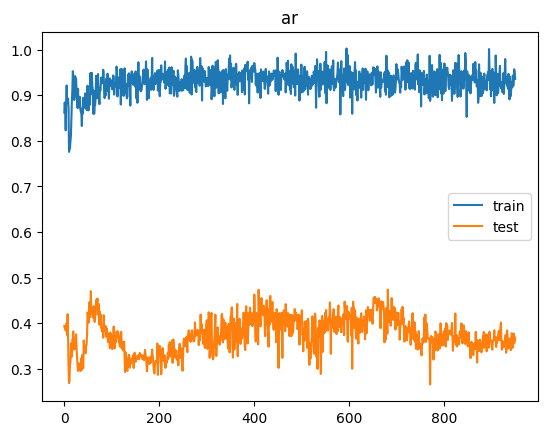

2/2 [==============================] - 0s 4ms/step


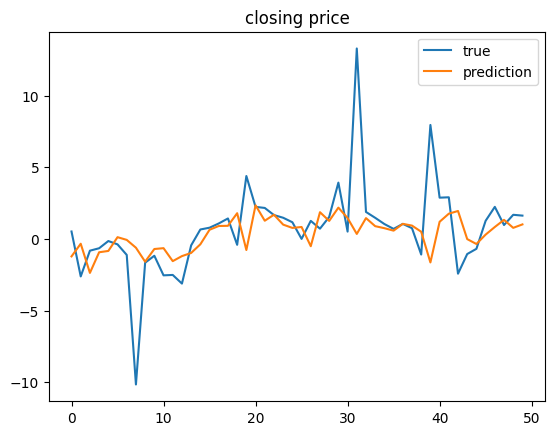

[MSE Baseline] train: 5.105705586951119  test: 5.010967196008289
Delta time with epochs = 950: 0:12:51.176958
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_8 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_9 (GRU)   

Time for epoch 53 is 0.9716541767120361 sec Generator Loss: 0.9951568841934204,  Discriminator_loss: 1.2231857776641846
Time for epoch 54 is 0.9983055591583252 sec Generator Loss: 0.9802156686782837,  Discriminator_loss: 1.2374372482299805
Time for epoch 55 is 1.0100064277648926 sec Generator Loss: 0.9535026550292969,  Discriminator_loss: 1.249631404876709
Time for epoch 56 is 0.9610910415649414 sec Generator Loss: 0.9645002484321594,  Discriminator_loss: 1.245837926864624
Time for epoch 57 is 0.9316976070404053 sec Generator Loss: 0.9422007203102112,  Discriminator_loss: 1.259623408317566
Time for epoch 58 is 0.9675135612487793 sec Generator Loss: 0.9423741698265076,  Discriminator_loss: 1.2624093294143677
Time for epoch 59 is 0.9820220470428467 sec Generator Loss: 0.934080958366394,  Discriminator_loss: 1.2801721096038818
Time for epoch 60 is 0.9729306697845459 sec Generator Loss: 0.9380601048469543,  Discriminator_loss: 1.2736202478408813
Time for epoch 61 is 0.97226881980896 sec Ge

Time for epoch 122 is 0.8509957790374756 sec Generator Loss: 0.8550629615783691,  Discriminator_loss: 1.3124154806137085
Time for epoch 123 is 0.8929295539855957 sec Generator Loss: 0.8586238622665405,  Discriminator_loss: 1.3079955577850342
Time for epoch 124 is 0.9870035648345947 sec Generator Loss: 0.8537193536758423,  Discriminator_loss: 1.321591854095459
Time for epoch 125 is 0.9260523319244385 sec Generator Loss: 0.8492031097412109,  Discriminator_loss: 1.3156496286392212
Time for epoch 126 is 1.0167977809906006 sec Generator Loss: 0.8561045527458191,  Discriminator_loss: 1.3131190538406372
Time for epoch 127 is 1.0092661380767822 sec Generator Loss: 0.8409474492073059,  Discriminator_loss: 1.32192862033844
Time for epoch 128 is 0.9869391918182373 sec Generator Loss: 0.8412167429924011,  Discriminator_loss: 1.3116313219070435
Time for epoch 129 is 0.8881649971008301 sec Generator Loss: 0.853182852268219,  Discriminator_loss: 1.3086562156677246
Time for epoch 130 is 0.902851343154

Time for epoch 190 is 1.0495123863220215 sec Generator Loss: 0.8470085263252258,  Discriminator_loss: 1.3270320892333984
Time for epoch 191 is 0.9865725040435791 sec Generator Loss: 0.8375009298324585,  Discriminator_loss: 1.3264681100845337
Time for epoch 192 is 0.917595386505127 sec Generator Loss: 0.8415496349334717,  Discriminator_loss: 1.3208434581756592
Time for epoch 193 is 0.917926549911499 sec Generator Loss: 0.8502482175827026,  Discriminator_loss: 1.32013738155365
Time for epoch 194 is 0.9340963363647461 sec Generator Loss: 0.8474434614181519,  Discriminator_loss: 1.316970705986023
Time for epoch 195 is 0.941309928894043 sec Generator Loss: 0.8375251293182373,  Discriminator_loss: 1.3239001035690308
Time for epoch 196 is 0.9233582019805908 sec Generator Loss: 0.8417186737060547,  Discriminator_loss: 1.3174612522125244
Time for epoch 197 is 0.9154162406921387 sec Generator Loss: 0.8462518453598022,  Discriminator_loss: 1.3141636848449707
Time for epoch 198 is 0.91187095642089

Time for epoch 259 is 0.9188888072967529 sec Generator Loss: 0.858479380607605,  Discriminator_loss: 1.3066853284835815
Time for epoch 260 is 0.9425656795501709 sec Generator Loss: 0.8435624837875366,  Discriminator_loss: 1.3253111839294434
Time for epoch 261 is 0.9142494201660156 sec Generator Loss: 0.8493962287902832,  Discriminator_loss: 1.310226321220398
Time for epoch 262 is 0.9511265754699707 sec Generator Loss: 0.8606889247894287,  Discriminator_loss: 1.3124345541000366
Time for epoch 263 is 0.9348187446594238 sec Generator Loss: 0.8453658819198608,  Discriminator_loss: 1.317542552947998
Time for epoch 264 is 0.9497809410095215 sec Generator Loss: 0.8399515151977539,  Discriminator_loss: 1.3228869438171387
Time for epoch 265 is 0.9089210033416748 sec Generator Loss: 0.846287727355957,  Discriminator_loss: 1.3239657878875732
Time for epoch 266 is 0.9210004806518555 sec Generator Loss: 0.8369733691215515,  Discriminator_loss: 1.315061092376709
Time for epoch 267 is 0.9232749938964

Time for epoch 327 is 1.0512762069702148 sec Generator Loss: 0.8510561585426331,  Discriminator_loss: 1.3133039474487305
Time for epoch 328 is 1.0087387561798096 sec Generator Loss: 0.8533589243888855,  Discriminator_loss: 1.3135284185409546
Time for epoch 329 is 1.0195937156677246 sec Generator Loss: 0.8555396795272827,  Discriminator_loss: 1.3126364946365356
Time for epoch 330 is 1.0232515335083008 sec Generator Loss: 0.8390539288520813,  Discriminator_loss: 1.3197698593139648
Time for epoch 331 is 0.9451484680175781 sec Generator Loss: 0.8484242558479309,  Discriminator_loss: 1.3140792846679688
Time for epoch 332 is 1.0154109001159668 sec Generator Loss: 0.8473079204559326,  Discriminator_loss: 1.3087397813796997
Time for epoch 333 is 0.9134254455566406 sec Generator Loss: 0.8619610667228699,  Discriminator_loss: 1.313228726387024
Time for epoch 334 is 1.0035810470581055 sec Generator Loss: 0.8530074954032898,  Discriminator_loss: 1.3196219205856323
Time for epoch 335 is 1.050248384

Time for epoch 395 is 0.8785591125488281 sec Generator Loss: 0.8559376001358032,  Discriminator_loss: 1.3158034086227417
Time for epoch 396 is 0.8738467693328857 sec Generator Loss: 0.8504480123519897,  Discriminator_loss: 1.314060091972351
Time for epoch 397 is 0.8567361831665039 sec Generator Loss: 0.8557361960411072,  Discriminator_loss: 1.3075817823410034
Time for epoch 398 is 0.8782248497009277 sec Generator Loss: 0.8528802990913391,  Discriminator_loss: 1.3158670663833618
Time for epoch 399 is 0.8905918598175049 sec Generator Loss: 0.8548417687416077,  Discriminator_loss: 1.3133597373962402
Time for epoch 400 is 0.8910071849822998 sec Generator Loss: 0.8478989005088806,  Discriminator_loss: 1.3085343837738037
Time for epoch 401 is 0.8920156955718994 sec Generator Loss: 0.8431277275085449,  Discriminator_loss: 1.3115731477737427
Time for epoch 402 is 0.8698301315307617 sec Generator Loss: 0.8583661317825317,  Discriminator_loss: 1.3049997091293335
Time for epoch 403 is 0.873005628

Time for epoch 463 is 0.9104738235473633 sec Generator Loss: 0.8523943424224854,  Discriminator_loss: 1.3106969594955444
Time for epoch 464 is 0.8927655220031738 sec Generator Loss: 0.8543894290924072,  Discriminator_loss: 1.3121142387390137
Time for epoch 465 is 0.9733555316925049 sec Generator Loss: 0.8717230558395386,  Discriminator_loss: 1.2973426580429077
Time for epoch 466 is 0.9857125282287598 sec Generator Loss: 0.8567842245101929,  Discriminator_loss: 1.3083690404891968
Time for epoch 467 is 0.900183916091919 sec Generator Loss: 0.8730806112289429,  Discriminator_loss: 1.3044544458389282
Time for epoch 468 is 0.8746347427368164 sec Generator Loss: 0.8640409708023071,  Discriminator_loss: 1.3061574697494507
Time for epoch 469 is 1.2123587131500244 sec Generator Loss: 0.8733315467834473,  Discriminator_loss: 1.2962197065353394
Time for epoch 470 is 1.0200374126434326 sec Generator Loss: 0.858788788318634,  Discriminator_loss: 1.3200103044509888
Time for epoch 471 is 1.1611809730

Time for epoch 531 is 0.8569052219390869 sec Generator Loss: 0.8603821992874146,  Discriminator_loss: 1.3007824420928955
Time for epoch 532 is 0.8366460800170898 sec Generator Loss: 0.8603057861328125,  Discriminator_loss: 1.315110445022583
Time for epoch 533 is 0.8297202587127686 sec Generator Loss: 0.854608416557312,  Discriminator_loss: 1.3176804780960083
Time for epoch 534 is 0.8283801078796387 sec Generator Loss: 0.8690125942230225,  Discriminator_loss: 1.3070354461669922
Time for epoch 535 is 0.8503992557525635 sec Generator Loss: 0.8591606020927429,  Discriminator_loss: 1.3027960062026978
Time for epoch 536 is 0.8404114246368408 sec Generator Loss: 0.8616376519203186,  Discriminator_loss: 1.3099007606506348
Time for epoch 537 is 0.8871848583221436 sec Generator Loss: 0.8677838444709778,  Discriminator_loss: 1.301900863647461
Time for epoch 538 is 0.9148845672607422 sec Generator Loss: 0.8718896508216858,  Discriminator_loss: 1.2980879545211792
Time for epoch 539 is 0.89759302139

Time for epoch 599 is 0.9569015502929688 sec Generator Loss: 0.8805255889892578,  Discriminator_loss: 1.295915126800537
Time for epoch 600 is 0.8511581420898438 sec Generator Loss: 0.8691127896308899,  Discriminator_loss: 1.2985883951187134
Time for epoch 601 is 0.842160701751709 sec Generator Loss: 0.8703882098197937,  Discriminator_loss: 1.297524333000183
Time for epoch 602 is 0.8325545787811279 sec Generator Loss: 0.8729009628295898,  Discriminator_loss: 1.31168532371521
Time for epoch 603 is 0.8399972915649414 sec Generator Loss: 0.8729369044303894,  Discriminator_loss: 1.3014731407165527
Time for epoch 604 is 0.8383347988128662 sec Generator Loss: 0.8656070828437805,  Discriminator_loss: 1.3071497678756714
Time for epoch 605 is 0.8315050601959229 sec Generator Loss: 0.8720239400863647,  Discriminator_loss: 1.3025624752044678
Time for epoch 606 is 0.834726095199585 sec Generator Loss: 0.8828074336051941,  Discriminator_loss: 1.3012545108795166
Time for epoch 607 is 0.84603714942932

Time for epoch 668 is 0.8529524803161621 sec Generator Loss: 0.8809720277786255,  Discriminator_loss: 1.3051506280899048
Time for epoch 669 is 0.8325595855712891 sec Generator Loss: 0.8637940287590027,  Discriminator_loss: 1.3095091581344604
Time for epoch 670 is 0.889829158782959 sec Generator Loss: 0.8797279596328735,  Discriminator_loss: 1.2950886487960815
Time for epoch 671 is 0.8544671535491943 sec Generator Loss: 0.8750305771827698,  Discriminator_loss: 1.299486756324768
Time for epoch 672 is 0.8961350917816162 sec Generator Loss: 0.8676204681396484,  Discriminator_loss: 1.3170334100723267
Time for epoch 673 is 0.8913650512695312 sec Generator Loss: 0.8816524147987366,  Discriminator_loss: 1.2889213562011719
Time for epoch 674 is 0.8412353992462158 sec Generator Loss: 0.877346932888031,  Discriminator_loss: 1.299403190612793
Time for epoch 675 is 0.9409475326538086 sec Generator Loss: 0.8734481930732727,  Discriminator_loss: 1.2996994256973267
Time for epoch 676 is 0.989190340042

Time for epoch 736 is 0.943596601486206 sec Generator Loss: 0.8837661147117615,  Discriminator_loss: 1.294913411140442
Time for epoch 737 is 0.9020304679870605 sec Generator Loss: 0.8848013281822205,  Discriminator_loss: 1.2855989933013916
Time for epoch 738 is 0.8902878761291504 sec Generator Loss: 0.869017481803894,  Discriminator_loss: 1.30353844165802
Time for epoch 739 is 0.943772554397583 sec Generator Loss: 0.8738371729850769,  Discriminator_loss: 1.3060368299484253
Time for epoch 740 is 0.9075665473937988 sec Generator Loss: 0.8737870454788208,  Discriminator_loss: 1.3004591464996338
Time for epoch 741 is 0.9009218215942383 sec Generator Loss: 0.8566197156906128,  Discriminator_loss: 1.3081886768341064
Time for epoch 742 is 0.9172062873840332 sec Generator Loss: 0.8691629767417908,  Discriminator_loss: 1.2953521013259888
Time for epoch 743 is 0.8944277763366699 sec Generator Loss: 0.8653454184532166,  Discriminator_loss: 1.3026490211486816
Time for epoch 744 is 0.87655663490295

Time for epoch 804 is 1.0165574550628662 sec Generator Loss: 0.8867189884185791,  Discriminator_loss: 1.2971665859222412
Time for epoch 805 is 0.9535722732543945 sec Generator Loss: 0.8861202597618103,  Discriminator_loss: 1.2949912548065186
Time for epoch 806 is 0.9528322219848633 sec Generator Loss: 0.8819648027420044,  Discriminator_loss: 1.286903738975525
Time for epoch 807 is 0.9616780281066895 sec Generator Loss: 0.8972660899162292,  Discriminator_loss: 1.2823843955993652
Time for epoch 808 is 0.9630918502807617 sec Generator Loss: 0.8863481879234314,  Discriminator_loss: 1.2978286743164062
Time for epoch 809 is 0.9521713256835938 sec Generator Loss: 0.8807674050331116,  Discriminator_loss: 1.3016270399093628
Time for epoch 810 is 0.9578795433044434 sec Generator Loss: 0.8757084012031555,  Discriminator_loss: 1.3006247282028198
Time for epoch 811 is 0.9829707145690918 sec Generator Loss: 0.8920994400978088,  Discriminator_loss: 1.286034107208252
Time for epoch 812 is 1.0427212715

Time for epoch 872 is 0.9604811668395996 sec Generator Loss: 0.9064204692840576,  Discriminator_loss: 1.2800359725952148
Time for epoch 873 is 0.9519021511077881 sec Generator Loss: 0.891033947467804,  Discriminator_loss: 1.290306806564331
Time for epoch 874 is 0.9850928783416748 sec Generator Loss: 0.8985052108764648,  Discriminator_loss: 1.2849791049957275
Time for epoch 875 is 0.9637906551361084 sec Generator Loss: 0.8974947929382324,  Discriminator_loss: 1.2818273305892944
Time for epoch 876 is 0.9897291660308838 sec Generator Loss: 0.8985100984573364,  Discriminator_loss: 1.2938132286071777
Time for epoch 877 is 0.9697525501251221 sec Generator Loss: 0.9209783673286438,  Discriminator_loss: 1.2743457555770874
Time for epoch 878 is 0.9690821170806885 sec Generator Loss: 0.9069885015487671,  Discriminator_loss: 1.2802255153656006
Time for epoch 879 is 1.0644748210906982 sec Generator Loss: 0.9059099555015564,  Discriminator_loss: 1.281891942024231
Time for epoch 880 is 1.04541754722

Time for epoch 941 is 1.1264677047729492 sec Generator Loss: 0.8924919366836548,  Discriminator_loss: 1.2907633781433105
Time for epoch 942 is 1.3126583099365234 sec Generator Loss: 0.9042964577674866,  Discriminator_loss: 1.2754826545715332
Time for epoch 943 is 1.2175815105438232 sec Generator Loss: 0.9031341075897217,  Discriminator_loss: 1.2824207544326782
Time for epoch 944 is 1.1630709171295166 sec Generator Loss: 0.9051182270050049,  Discriminator_loss: 1.2803125381469727
Time for epoch 945 is 1.1252992153167725 sec Generator Loss: 0.9009564518928528,  Discriminator_loss: 1.28550124168396
Time for epoch 946 is 1.0308334827423096 sec Generator Loss: 0.8994305729866028,  Discriminator_loss: 1.2911967039108276
Time for epoch 947 is 1.1964373588562012 sec Generator Loss: 0.906616747379303,  Discriminator_loss: 1.2764513492584229
Time for epoch 948 is 1.1583380699157715 sec Generator Loss: 0.9059626460075378,  Discriminator_loss: 1.2773027420043945
Time for epoch 949 is 1.08164501190

Time for epoch 1009 is 0.9282011985778809 sec Generator Loss: 0.8927051424980164,  Discriminator_loss: 1.2850805521011353
Time for epoch 1010 is 0.9742069244384766 sec Generator Loss: 0.8936455249786377,  Discriminator_loss: 1.2929025888442993
Time for epoch 1011 is 0.9576456546783447 sec Generator Loss: 0.9076200723648071,  Discriminator_loss: 1.2766739130020142
Time for epoch 1012 is 0.9361240863800049 sec Generator Loss: 0.8954528570175171,  Discriminator_loss: 1.283586025238037
Time for epoch 1013 is 0.9424757957458496 sec Generator Loss: 0.9045479893684387,  Discriminator_loss: 1.2778594493865967
Time for epoch 1014 is 0.9892878532409668 sec Generator Loss: 0.9034665822982788,  Discriminator_loss: 1.2863701581954956
Time for epoch 1015 is 0.938420295715332 sec Generator Loss: 0.9122766852378845,  Discriminator_loss: 1.2887609004974365
Time for epoch 1016 is 0.9235765933990479 sec Generator Loss: 0.9045714735984802,  Discriminator_loss: 1.2885323762893677
Time for epoch 1017 is 0.9

Time for epoch 1077 is 1.042405605316162 sec Generator Loss: 0.896759569644928,  Discriminator_loss: 1.280629277229309
Time for epoch 1078 is 1.0678918361663818 sec Generator Loss: 0.9049257636070251,  Discriminator_loss: 1.2879105806350708
Time for epoch 1079 is 1.042076587677002 sec Generator Loss: 0.9057086110115051,  Discriminator_loss: 1.2740966081619263
Time for epoch 1080 is 1.1044528484344482 sec Generator Loss: 0.9187771081924438,  Discriminator_loss: 1.27806556224823
Time for epoch 1081 is 1.0697522163391113 sec Generator Loss: 0.897668719291687,  Discriminator_loss: 1.2859894037246704
Time for epoch 1082 is 1.0412356853485107 sec Generator Loss: 0.9035292267799377,  Discriminator_loss: 1.2770726680755615
Time for epoch 1083 is 1.027787685394287 sec Generator Loss: 0.9005933403968811,  Discriminator_loss: 1.274239182472229
Time for epoch 1084 is 1.1015090942382812 sec Generator Loss: 0.9170735478401184,  Discriminator_loss: 1.2813490629196167
Time for epoch 1085 is 1.07557034

Time for epoch 1145 is 1.0980021953582764 sec Generator Loss: 0.908040463924408,  Discriminator_loss: 1.2799136638641357
Time for epoch 1146 is 1.0455570220947266 sec Generator Loss: 0.9193605184555054,  Discriminator_loss: 1.2868084907531738
Time for epoch 1147 is 1.04148268699646 sec Generator Loss: 0.9062188267707825,  Discriminator_loss: 1.2828116416931152
Time for epoch 1148 is 1.0588321685791016 sec Generator Loss: 0.9166995286941528,  Discriminator_loss: 1.2711361646652222
Time for epoch 1149 is 1.040778636932373 sec Generator Loss: 0.9185866117477417,  Discriminator_loss: 1.2782949209213257
Time for epoch 1150 is 1.0467348098754883 sec Generator Loss: 0.9081564545631409,  Discriminator_loss: 1.282268762588501
Time for epoch 1151 is 1.0395946502685547 sec Generator Loss: 0.9286383986473083,  Discriminator_loss: 1.2741034030914307
Time for epoch 1152 is 1.0758311748504639 sec Generator Loss: 0.9168928861618042,  Discriminator_loss: 1.2851190567016602
Time for epoch 1153 is 1.0725

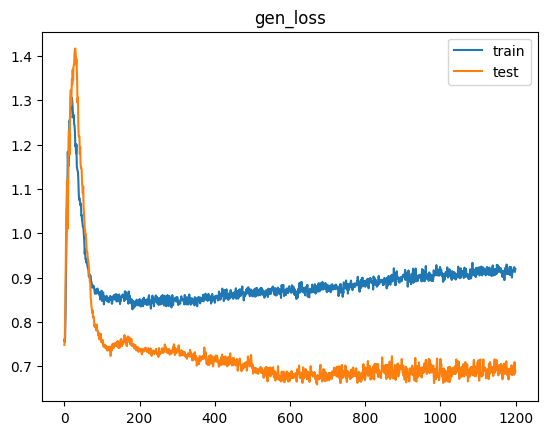

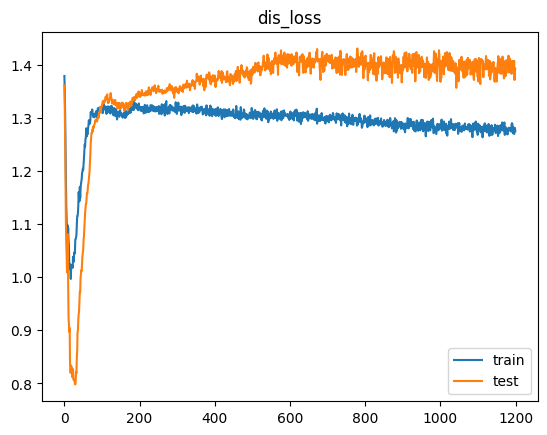

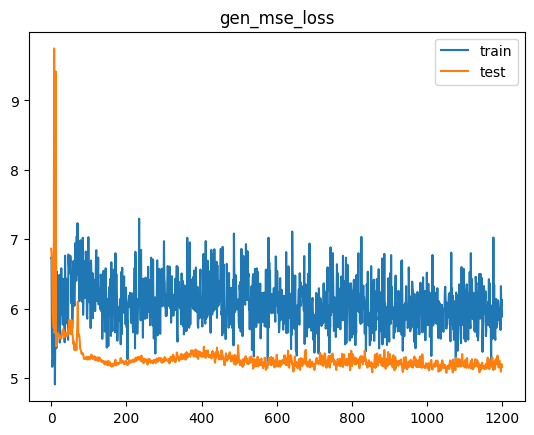

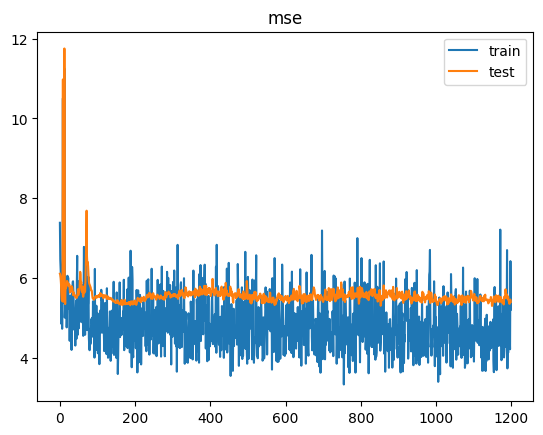

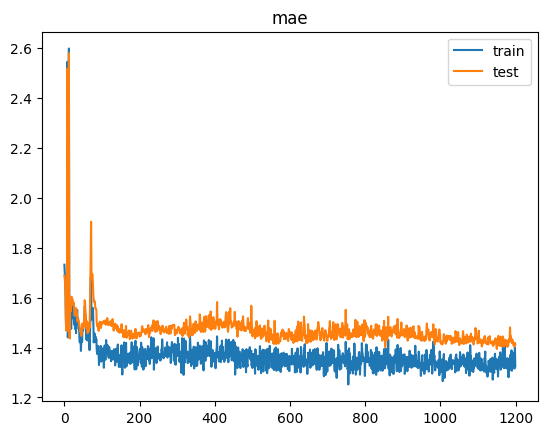

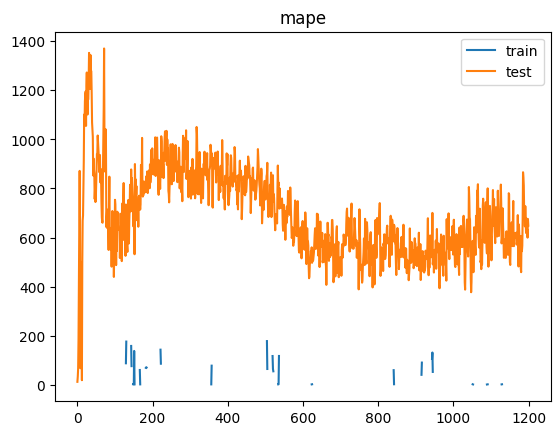

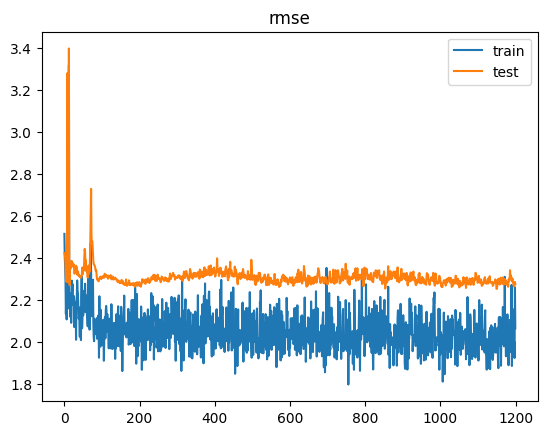

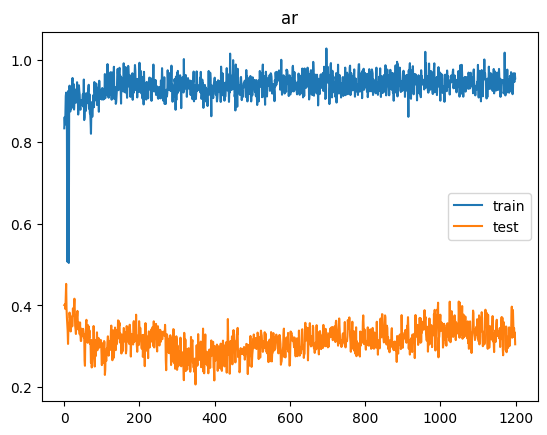

2/2 [==============================] - 0s 6ms/step


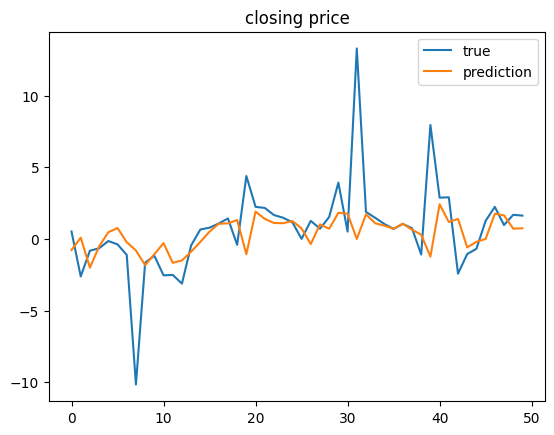

[MSE Baseline] train: 5.846298188220848  test: 5.010967196008289
Delta time with epochs = 1200: 0:19:32.149779
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_10 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_11 (GRU) 

Time for epoch 52 is 0.9044559001922607 sec Generator Loss: 1.1424670219421387,  Discriminator_loss: 1.1202486753463745
Time for epoch 53 is 0.8792915344238281 sec Generator Loss: 1.1298049688339233,  Discriminator_loss: 1.1379170417785645
Time for epoch 54 is 0.8794293403625488 sec Generator Loss: 1.1176129579544067,  Discriminator_loss: 1.136938452720642
Time for epoch 55 is 0.9535501003265381 sec Generator Loss: 1.1049847602844238,  Discriminator_loss: 1.14869225025177
Time for epoch 56 is 0.917731761932373 sec Generator Loss: 1.0808497667312622,  Discriminator_loss: 1.1573537588119507
Time for epoch 57 is 0.9092905521392822 sec Generator Loss: 1.081257700920105,  Discriminator_loss: 1.1670880317687988
Time for epoch 58 is 0.9064850807189941 sec Generator Loss: 1.0594072341918945,  Discriminator_loss: 1.199926733970642
Time for epoch 59 is 0.9051609039306641 sec Generator Loss: 1.0466958284378052,  Discriminator_loss: 1.1809076070785522
Time for epoch 60 is 0.9665985107421875 sec Ge

Time for epoch 121 is 0.8706119060516357 sec Generator Loss: 0.8926048278808594,  Discriminator_loss: 1.2928885221481323
Time for epoch 122 is 0.8346266746520996 sec Generator Loss: 0.8947147727012634,  Discriminator_loss: 1.2943100929260254
Time for epoch 123 is 0.8279104232788086 sec Generator Loss: 0.8922929167747498,  Discriminator_loss: 1.2986141443252563
Time for epoch 124 is 0.8450019359588623 sec Generator Loss: 0.8855943083763123,  Discriminator_loss: 1.302498698234558
Time for epoch 125 is 0.833756685256958 sec Generator Loss: 0.8876232504844666,  Discriminator_loss: 1.29446542263031
Time for epoch 126 is 0.8367249965667725 sec Generator Loss: 0.8964623212814331,  Discriminator_loss: 1.2989739179611206
Time for epoch 127 is 0.8233559131622314 sec Generator Loss: 0.8859487175941467,  Discriminator_loss: 1.291114330291748
Time for epoch 128 is 0.9347124099731445 sec Generator Loss: 0.8941768407821655,  Discriminator_loss: 1.2971100807189941
Time for epoch 129 is 1.1379756927490

Time for epoch 189 is 0.9397258758544922 sec Generator Loss: 0.8757368326187134,  Discriminator_loss: 1.2957284450531006
Time for epoch 190 is 1.0362787246704102 sec Generator Loss: 0.8730223178863525,  Discriminator_loss: 1.2938916683197021
Time for epoch 191 is 1.0785424709320068 sec Generator Loss: 0.8828266263008118,  Discriminator_loss: 1.2895641326904297
Time for epoch 192 is 1.0552246570587158 sec Generator Loss: 0.8860163688659668,  Discriminator_loss: 1.2945665121078491
Time for epoch 193 is 1.0540452003479004 sec Generator Loss: 0.8802959322929382,  Discriminator_loss: 1.291438102722168
Time for epoch 194 is 1.0547881126403809 sec Generator Loss: 0.8893304467201233,  Discriminator_loss: 1.2913340330123901
Time for epoch 195 is 1.081434726715088 sec Generator Loss: 0.8792069554328918,  Discriminator_loss: 1.2966694831848145
Time for epoch 196 is 1.0956461429595947 sec Generator Loss: 0.8796582221984863,  Discriminator_loss: 1.2944666147232056
Time for epoch 197 is 1.0024728775

Time for epoch 257 is 0.966188907623291 sec Generator Loss: 0.8680624961853027,  Discriminator_loss: 1.3024290800094604
Time for epoch 258 is 0.9567983150482178 sec Generator Loss: 0.8733947277069092,  Discriminator_loss: 1.3051718473434448
Time for epoch 259 is 0.9369988441467285 sec Generator Loss: 0.8679553866386414,  Discriminator_loss: 1.3124030828475952
Time for epoch 260 is 0.9137139320373535 sec Generator Loss: 0.8656280636787415,  Discriminator_loss: 1.3061140775680542
Time for epoch 261 is 0.9274775981903076 sec Generator Loss: 0.8604304194450378,  Discriminator_loss: 1.3090667724609375
Time for epoch 262 is 0.9168891906738281 sec Generator Loss: 0.8640002608299255,  Discriminator_loss: 1.315514326095581
Time for epoch 263 is 0.9476757049560547 sec Generator Loss: 0.8733350038528442,  Discriminator_loss: 1.297547698020935
Time for epoch 264 is 0.9127109050750732 sec Generator Loss: 0.8710306882858276,  Discriminator_loss: 1.3070992231369019
Time for epoch 265 is 1.13753962516

Time for epoch 325 is 0.9308218955993652 sec Generator Loss: 0.8652925491333008,  Discriminator_loss: 1.3015875816345215
Time for epoch 326 is 0.9070308208465576 sec Generator Loss: 0.8785601258277893,  Discriminator_loss: 1.306351900100708
Time for epoch 327 is 0.9131612777709961 sec Generator Loss: 0.8692042231559753,  Discriminator_loss: 1.303051471710205
Time for epoch 328 is 0.9511151313781738 sec Generator Loss: 0.868118405342102,  Discriminator_loss: 1.3041003942489624
Time for epoch 329 is 0.92081618309021 sec Generator Loss: 0.8815720677375793,  Discriminator_loss: 1.2949246168136597
Time for epoch 330 is 0.9107227325439453 sec Generator Loss: 0.8794436454772949,  Discriminator_loss: 1.302276372909546
Time for epoch 331 is 0.9255146980285645 sec Generator Loss: 0.8642557859420776,  Discriminator_loss: 1.3018741607666016
Time for epoch 332 is 0.9388809204101562 sec Generator Loss: 0.8741906881332397,  Discriminator_loss: 1.3058581352233887
Time for epoch 333 is 0.92670464515686

Time for epoch 394 is 1.0251951217651367 sec Generator Loss: 0.8866667151451111,  Discriminator_loss: 1.2986232042312622
Time for epoch 395 is 1.0555689334869385 sec Generator Loss: 0.8651370406150818,  Discriminator_loss: 1.3107554912567139
Time for epoch 396 is 0.9845240116119385 sec Generator Loss: 0.8668012619018555,  Discriminator_loss: 1.3018467426300049
Time for epoch 397 is 0.9344034194946289 sec Generator Loss: 0.8810622692108154,  Discriminator_loss: 1.2944241762161255
Time for epoch 398 is 0.9629526138305664 sec Generator Loss: 0.8733814358711243,  Discriminator_loss: 1.295609712600708
Time for epoch 399 is 0.9185092449188232 sec Generator Loss: 0.8738890290260315,  Discriminator_loss: 1.2999485731124878
Time for epoch 400 is 0.9367232322692871 sec Generator Loss: 0.875839352607727,  Discriminator_loss: 1.2961505651474
Time for epoch 401 is 0.9403238296508789 sec Generator Loss: 0.8724185228347778,  Discriminator_loss: 1.3065873384475708
Time for epoch 402 is 0.9062290191650

Time for epoch 462 is 0.9486486911773682 sec Generator Loss: 0.8824986219406128,  Discriminator_loss: 1.296613335609436
Time for epoch 463 is 0.9250898361206055 sec Generator Loss: 0.8813762068748474,  Discriminator_loss: 1.307969331741333
Time for epoch 464 is 0.9113690853118896 sec Generator Loss: 0.8649084568023682,  Discriminator_loss: 1.3077998161315918
Time for epoch 465 is 0.9068734645843506 sec Generator Loss: 0.8832482695579529,  Discriminator_loss: 1.2959985733032227
Time for epoch 466 is 0.8907463550567627 sec Generator Loss: 0.8711185455322266,  Discriminator_loss: 1.3034489154815674
Time for epoch 467 is 0.9225454330444336 sec Generator Loss: 0.8776805996894836,  Discriminator_loss: 1.300353765487671
Time for epoch 468 is 0.9400529861450195 sec Generator Loss: 0.8717861771583557,  Discriminator_loss: 1.3026494979858398
Time for epoch 469 is 0.9200990200042725 sec Generator Loss: 0.8640325665473938,  Discriminator_loss: 1.3148796558380127
Time for epoch 470 is 0.91524267196

Time for epoch 530 is 1.0539798736572266 sec Generator Loss: 0.867692768573761,  Discriminator_loss: 1.3003376722335815
Time for epoch 531 is 1.063267707824707 sec Generator Loss: 0.8919639587402344,  Discriminator_loss: 1.2997078895568848
Time for epoch 532 is 1.0501399040222168 sec Generator Loss: 0.8851121068000793,  Discriminator_loss: 1.291746735572815
Time for epoch 533 is 1.0422520637512207 sec Generator Loss: 0.8811448812484741,  Discriminator_loss: 1.2888609170913696
Time for epoch 534 is 1.038226842880249 sec Generator Loss: 0.8852593898773193,  Discriminator_loss: 1.2926386594772339
Time for epoch 535 is 1.0021429061889648 sec Generator Loss: 0.8944861888885498,  Discriminator_loss: 1.2931456565856934
Time for epoch 536 is 0.9917776584625244 sec Generator Loss: 0.8738044500350952,  Discriminator_loss: 1.3019356727600098
Time for epoch 537 is 0.9802756309509277 sec Generator Loss: 0.8724471926689148,  Discriminator_loss: 1.2989888191223145
Time for epoch 538 is 0.985707521438

Time for epoch 599 is 0.996894121170044 sec Generator Loss: 0.8930683135986328,  Discriminator_loss: 1.285911202430725
Time for epoch 600 is 0.9937241077423096 sec Generator Loss: 0.8878924250602722,  Discriminator_loss: 1.295276403427124
Time for epoch 601 is 0.961881160736084 sec Generator Loss: 0.8862267136573792,  Discriminator_loss: 1.2863154411315918
Time for epoch 602 is 0.9724199771881104 sec Generator Loss: 0.8933916687965393,  Discriminator_loss: 1.2871277332305908
Time for epoch 603 is 0.9418425559997559 sec Generator Loss: 0.8959218263626099,  Discriminator_loss: 1.2904715538024902
Time for epoch 604 is 0.9514493942260742 sec Generator Loss: 0.8840169906616211,  Discriminator_loss: 1.2872706651687622
Time for epoch 605 is 1.0852670669555664 sec Generator Loss: 0.8901206254959106,  Discriminator_loss: 1.2880994081497192
Time for epoch 606 is 1.001302719116211 sec Generator Loss: 0.8999540209770203,  Discriminator_loss: 1.2769044637680054
Time for epoch 607 is 1.0158145427703

Time for epoch 667 is 0.9590780735015869 sec Generator Loss: 0.910844087600708,  Discriminator_loss: 1.279252290725708
Time for epoch 668 is 0.9671666622161865 sec Generator Loss: 0.8909915089607239,  Discriminator_loss: 1.2979236841201782
Time for epoch 669 is 0.986222505569458 sec Generator Loss: 0.894966185092926,  Discriminator_loss: 1.2832790613174438
Time for epoch 670 is 0.9737234115600586 sec Generator Loss: 0.8892648220062256,  Discriminator_loss: 1.2848728895187378
Time for epoch 671 is 1.0184438228607178 sec Generator Loss: 0.8942241072654724,  Discriminator_loss: 1.2885769605636597
Time for epoch 672 is 0.9555413722991943 sec Generator Loss: 0.8972790837287903,  Discriminator_loss: 1.2864127159118652
Time for epoch 673 is 0.9716362953186035 sec Generator Loss: 0.8900694847106934,  Discriminator_loss: 1.2935763597488403
Time for epoch 674 is 0.9651062488555908 sec Generator Loss: 0.8954334259033203,  Discriminator_loss: 1.2865874767303467
Time for epoch 675 is 1.042942762374

Time for epoch 735 is 0.9738161563873291 sec Generator Loss: 0.8996878862380981,  Discriminator_loss: 1.292744517326355
Time for epoch 736 is 1.1319293975830078 sec Generator Loss: 0.8989238142967224,  Discriminator_loss: 1.2908389568328857
Time for epoch 737 is 1.2444260120391846 sec Generator Loss: 0.8946555852890015,  Discriminator_loss: 1.2838774919509888
Time for epoch 738 is 1.3168666362762451 sec Generator Loss: 0.8862265944480896,  Discriminator_loss: 1.2904813289642334
Time for epoch 739 is 1.1529910564422607 sec Generator Loss: 0.9026944637298584,  Discriminator_loss: 1.286586046218872
Time for epoch 740 is 1.197983980178833 sec Generator Loss: 0.900894045829773,  Discriminator_loss: 1.2836418151855469
Time for epoch 741 is 1.155334711074829 sec Generator Loss: 0.9093974828720093,  Discriminator_loss: 1.2784260511398315
Time for epoch 742 is 1.1602036952972412 sec Generator Loss: 0.8923302888870239,  Discriminator_loss: 1.2881125211715698
Time for epoch 743 is 1.1911044120788

Time for epoch 804 is 1.2008790969848633 sec Generator Loss: 0.900051474571228,  Discriminator_loss: 1.2717119455337524
Time for epoch 805 is 1.245534896850586 sec Generator Loss: 0.9123581647872925,  Discriminator_loss: 1.2749770879745483
Time for epoch 806 is 1.160168170928955 sec Generator Loss: 0.9115359783172607,  Discriminator_loss: 1.2791072130203247
Time for epoch 807 is 1.0946953296661377 sec Generator Loss: 0.9034024477005005,  Discriminator_loss: 1.2802215814590454
Time for epoch 808 is 1.111924171447754 sec Generator Loss: 0.8940839767456055,  Discriminator_loss: 1.2816942930221558
Time for epoch 809 is 1.0981614589691162 sec Generator Loss: 0.9021740555763245,  Discriminator_loss: 1.2742936611175537
Time for epoch 810 is 1.0478100776672363 sec Generator Loss: 0.9033598303794861,  Discriminator_loss: 1.2781590223312378
Time for epoch 811 is 1.1081273555755615 sec Generator Loss: 0.9070884585380554,  Discriminator_loss: 1.2722049951553345
Time for epoch 812 is 1.066482067108

Time for epoch 873 is 1.0659732818603516 sec Generator Loss: 0.921780526638031,  Discriminator_loss: 1.2643485069274902
Time for epoch 874 is 1.1323790550231934 sec Generator Loss: 0.9078237414360046,  Discriminator_loss: 1.2731711864471436
Time for epoch 875 is 1.0822651386260986 sec Generator Loss: 0.9238827228546143,  Discriminator_loss: 1.2690184116363525
Time for epoch 876 is 1.0685288906097412 sec Generator Loss: 0.9079239964485168,  Discriminator_loss: 1.2742043733596802
Time for epoch 877 is 1.12052583694458 sec Generator Loss: 0.91241854429245,  Discriminator_loss: 1.2727534770965576
Time for epoch 878 is 1.0315864086151123 sec Generator Loss: 0.9149645566940308,  Discriminator_loss: 1.2734606266021729
Time for epoch 879 is 1.0758452415466309 sec Generator Loss: 0.9249547719955444,  Discriminator_loss: 1.264746904373169
Time for epoch 880 is 1.2394027709960938 sec Generator Loss: 0.9211536049842834,  Discriminator_loss: 1.2755733728408813
Time for epoch 881 is 1.40690755844116

Time for epoch 942 is 1.0962204933166504 sec Generator Loss: 0.9198756217956543,  Discriminator_loss: 1.2713969945907593
Time for epoch 943 is 1.0688633918762207 sec Generator Loss: 0.9011255502700806,  Discriminator_loss: 1.277461290359497
Time for epoch 944 is 1.3359742164611816 sec Generator Loss: 0.9126019477844238,  Discriminator_loss: 1.2664921283721924
Time for epoch 945 is 1.5011589527130127 sec Generator Loss: 0.9132141470909119,  Discriminator_loss: 1.2767157554626465
Time for epoch 946 is 1.22100830078125 sec Generator Loss: 0.9092652201652527,  Discriminator_loss: 1.2666139602661133
Time for epoch 947 is 1.2838141918182373 sec Generator Loss: 0.9061024785041809,  Discriminator_loss: 1.285125970840454
Time for epoch 948 is 1.2702157497406006 sec Generator Loss: 0.9152302145957947,  Discriminator_loss: 1.276171326637268
Time for epoch 949 is 1.3797531127929688 sec Generator Loss: 0.9310166239738464,  Discriminator_loss: 1.2631988525390625
Time for epoch 950 is 1.5488801002502

Time for epoch 1010 is 1.1211633682250977 sec Generator Loss: 0.91133052110672,  Discriminator_loss: 1.266716480255127
Time for epoch 1011 is 1.1876246929168701 sec Generator Loss: 0.9171221256256104,  Discriminator_loss: 1.2704612016677856
Time for epoch 1012 is 1.130225658416748 sec Generator Loss: 0.9100643396377563,  Discriminator_loss: 1.26930832862854
Time for epoch 1013 is 1.2151129245758057 sec Generator Loss: 0.9215249419212341,  Discriminator_loss: 1.2749165296554565
Time for epoch 1014 is 1.1001183986663818 sec Generator Loss: 0.9100238680839539,  Discriminator_loss: 1.2786420583724976
Time for epoch 1015 is 1.118760108947754 sec Generator Loss: 0.9310617446899414,  Discriminator_loss: 1.2589627504348755
Time for epoch 1016 is 1.0974185466766357 sec Generator Loss: 0.9215279817581177,  Discriminator_loss: 1.268864393234253
Time for epoch 1017 is 1.2081058025360107 sec Generator Loss: 0.9035029411315918,  Discriminator_loss: 1.2844761610031128
Time for epoch 1018 is 1.1459329

Time for epoch 1078 is 1.2049918174743652 sec Generator Loss: 0.9242333173751831,  Discriminator_loss: 1.2670553922653198
Time for epoch 1079 is 1.2509362697601318 sec Generator Loss: 0.9231890439987183,  Discriminator_loss: 1.2659268379211426
Time for epoch 1080 is 1.227858543395996 sec Generator Loss: 0.9239675402641296,  Discriminator_loss: 1.2767245769500732
Time for epoch 1081 is 1.1964137554168701 sec Generator Loss: 0.9326367974281311,  Discriminator_loss: 1.2569087743759155
Time for epoch 1082 is 1.2415645122528076 sec Generator Loss: 0.9239042401313782,  Discriminator_loss: 1.2738431692123413
Time for epoch 1083 is 1.2375695705413818 sec Generator Loss: 0.9257805347442627,  Discriminator_loss: 1.2746608257293701
Time for epoch 1084 is 1.253549575805664 sec Generator Loss: 0.9316217303276062,  Discriminator_loss: 1.2620114088058472
Time for epoch 1085 is 1.231651782989502 sec Generator Loss: 0.9085018038749695,  Discriminator_loss: 1.281920075416565
Time for epoch 1086 is 1.199

Time for epoch 1146 is 1.4004719257354736 sec Generator Loss: 0.9248222708702087,  Discriminator_loss: 1.2623207569122314
Time for epoch 1147 is 1.713869571685791 sec Generator Loss: 0.9249435067176819,  Discriminator_loss: 1.2774096727371216
Time for epoch 1148 is 1.4833204746246338 sec Generator Loss: 0.9265878200531006,  Discriminator_loss: 1.264230728149414
Time for epoch 1149 is 1.2276923656463623 sec Generator Loss: 0.9263135194778442,  Discriminator_loss: 1.2605868577957153
Time for epoch 1150 is 1.2844624519348145 sec Generator Loss: 0.9101610779762268,  Discriminator_loss: 1.2735952138900757
Time for epoch 1151 is 1.358475923538208 sec Generator Loss: 0.9242444038391113,  Discriminator_loss: 1.2632604837417603
Time for epoch 1152 is 1.1620111465454102 sec Generator Loss: 0.9202434420585632,  Discriminator_loss: 1.2666726112365723
Time for epoch 1153 is 1.1147842407226562 sec Generator Loss: 0.9257045984268188,  Discriminator_loss: 1.266111135482788
Time for epoch 1154 is 1.159

Time for epoch 1214 is 1.1974737644195557 sec Generator Loss: 0.9173933863639832,  Discriminator_loss: 1.273938536643982
Time for epoch 1215 is 1.2630817890167236 sec Generator Loss: 0.9135639667510986,  Discriminator_loss: 1.2728047370910645
Time for epoch 1216 is 1.2532715797424316 sec Generator Loss: 0.9279854893684387,  Discriminator_loss: 1.259998083114624
Time for epoch 1217 is 1.3701422214508057 sec Generator Loss: 0.9156484007835388,  Discriminator_loss: 1.2766910791397095
Time for epoch 1218 is 1.32757568359375 sec Generator Loss: 0.9206495881080627,  Discriminator_loss: 1.2682478427886963
Time for epoch 1219 is 1.328519344329834 sec Generator Loss: 0.9218056201934814,  Discriminator_loss: 1.2832800149917603
Time for epoch 1220 is 1.382239818572998 sec Generator Loss: 0.9210617542266846,  Discriminator_loss: 1.2629308700561523
Time for epoch 1221 is 1.1993017196655273 sec Generator Loss: 0.9123325347900391,  Discriminator_loss: 1.282873272895813
Time for epoch 1222 is 1.193242

Time for epoch 1282 is 1.1661856174468994 sec Generator Loss: 0.9265950322151184,  Discriminator_loss: 1.2612441778182983
Time for epoch 1283 is 1.1957359313964844 sec Generator Loss: 0.928950309753418,  Discriminator_loss: 1.2738476991653442
Time for epoch 1284 is 1.22735595703125 sec Generator Loss: 0.931151807308197,  Discriminator_loss: 1.2660861015319824
Time for epoch 1285 is 1.171966314315796 sec Generator Loss: 0.9119412899017334,  Discriminator_loss: 1.280542254447937
Time for epoch 1286 is 1.2256877422332764 sec Generator Loss: 0.9181172847747803,  Discriminator_loss: 1.2779138088226318
Time for epoch 1287 is 1.2039594650268555 sec Generator Loss: 0.9312246441841125,  Discriminator_loss: 1.269184947013855
Time for epoch 1288 is 1.2073941230773926 sec Generator Loss: 0.9082491993904114,  Discriminator_loss: 1.270843744277954
Time for epoch 1289 is 1.221367359161377 sec Generator Loss: 0.9228103756904602,  Discriminator_loss: 1.2722514867782593
Time for epoch 1290 is 1.14052796

Time for epoch 1350 is 1.2606899738311768 sec Generator Loss: 0.9290825128555298,  Discriminator_loss: 1.2627754211425781
Time for epoch 1351 is 1.3545124530792236 sec Generator Loss: 0.9250443577766418,  Discriminator_loss: 1.2671078443527222
Time for epoch 1352 is 1.2683992385864258 sec Generator Loss: 0.9335386157035828,  Discriminator_loss: 1.2554168701171875
Time for epoch 1353 is 1.1097383499145508 sec Generator Loss: 0.9334089756011963,  Discriminator_loss: 1.2667063474655151
Time for epoch 1354 is 1.058551549911499 sec Generator Loss: 0.9258975386619568,  Discriminator_loss: 1.2666252851486206
Time for epoch 1355 is 1.0688245296478271 sec Generator Loss: 0.9134018421173096,  Discriminator_loss: 1.266709804534912
Time for epoch 1356 is 1.088524341583252 sec Generator Loss: 0.9251477122306824,  Discriminator_loss: 1.2687839269638062
Time for epoch 1357 is 1.097071647644043 sec Generator Loss: 0.9244587421417236,  Discriminator_loss: 1.2648030519485474
Time for epoch 1358 is 1.093

Time for epoch 1418 is 1.0917167663574219 sec Generator Loss: 0.9301652908325195,  Discriminator_loss: 1.2704535722732544
Time for epoch 1419 is 1.0945611000061035 sec Generator Loss: 0.9362810850143433,  Discriminator_loss: 1.264843463897705
Time for epoch 1420 is 1.0956759452819824 sec Generator Loss: 0.927054226398468,  Discriminator_loss: 1.2617040872573853
Time for epoch 1421 is 1.100799798965454 sec Generator Loss: 0.9212581515312195,  Discriminator_loss: 1.2822387218475342
Time for epoch 1422 is 1.0853188037872314 sec Generator Loss: 0.9204599857330322,  Discriminator_loss: 1.2714765071868896
Time for epoch 1423 is 1.0756030082702637 sec Generator Loss: 0.9308286309242249,  Discriminator_loss: 1.2597277164459229
Time for epoch 1424 is 1.0701475143432617 sec Generator Loss: 0.9268636703491211,  Discriminator_loss: 1.2702828645706177
Time for epoch 1425 is 1.0949945449829102 sec Generator Loss: 0.9121407866477966,  Discriminator_loss: 1.2714506387710571
Time for epoch 1426 is 1.17

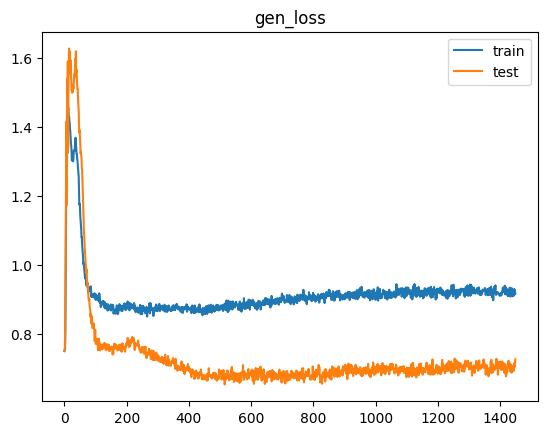

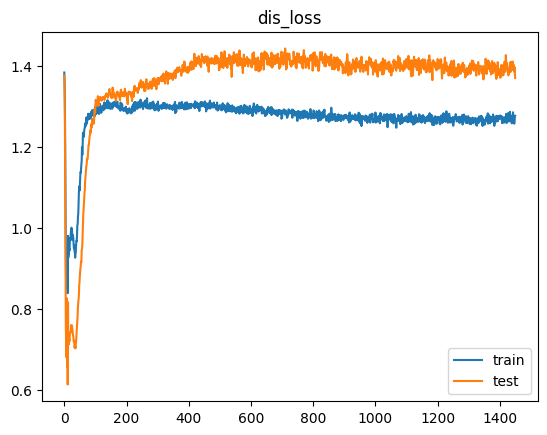

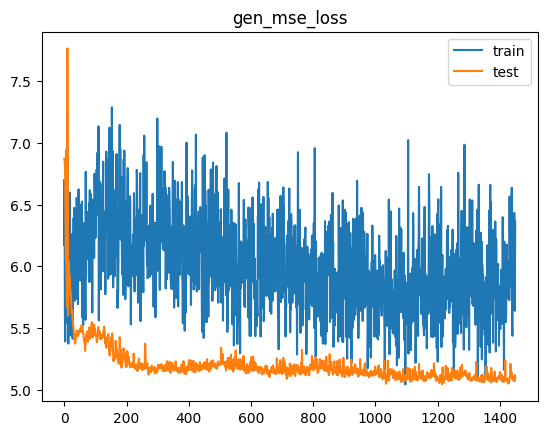

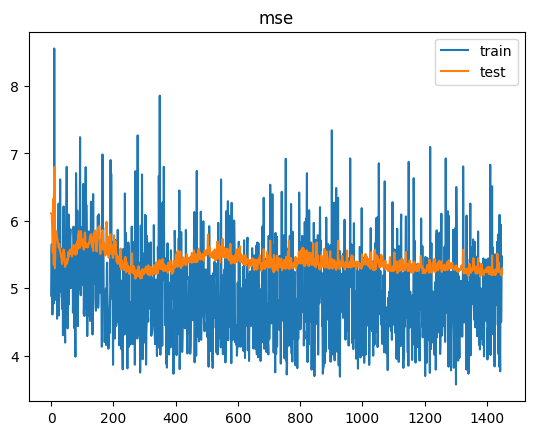

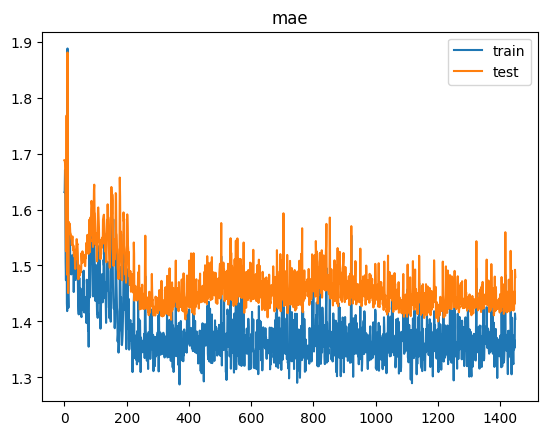

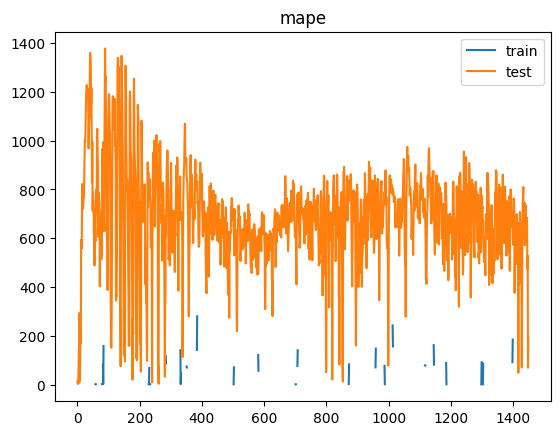

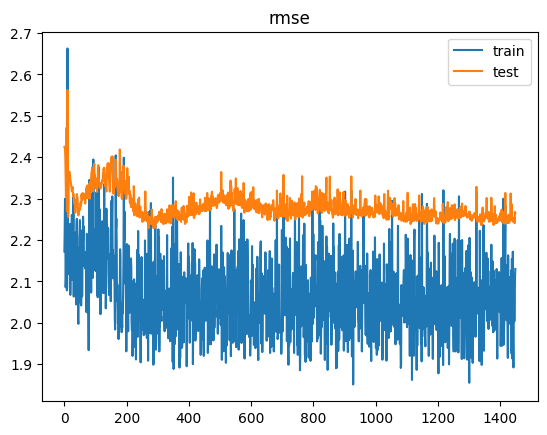

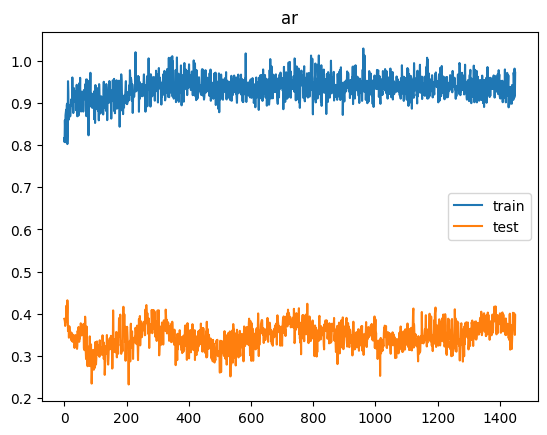

2/2 [==============================] - 0s 6ms/step


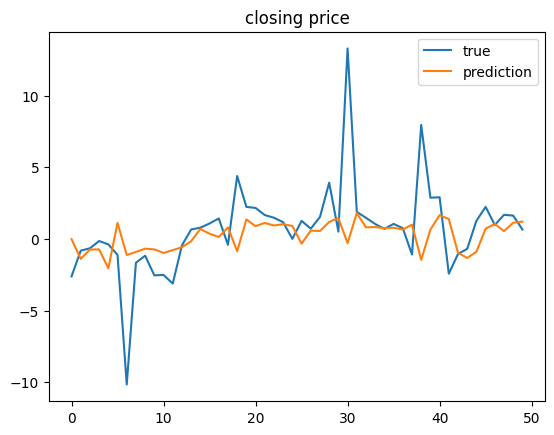

[MSE Baseline] train: 4.257581502191749  test: 5.023830941163814
Delta time with epochs = 1450: 0:26:15.065293


In [21]:
for epochs in [950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_12 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_13 (GRU)                (None, 10)                660       
                                                           

Time for epoch 53 is 1.2047085762023926 sec Generator Loss: 1.045257806777954,  Discriminator_loss: 1.1641170978546143
Time for epoch 54 is 1.2008564472198486 sec Generator Loss: 1.0373108386993408,  Discriminator_loss: 1.1937061548233032
Time for epoch 55 is 1.1852097511291504 sec Generator Loss: 1.0237187147140503,  Discriminator_loss: 1.1951961517333984
Time for epoch 56 is 1.234753131866455 sec Generator Loss: 0.997232973575592,  Discriminator_loss: 1.2159605026245117
Time for epoch 57 is 1.223613977432251 sec Generator Loss: 1.0025757551193237,  Discriminator_loss: 1.205381989479065
Time for epoch 58 is 1.2133970260620117 sec Generator Loss: 0.9965968728065491,  Discriminator_loss: 1.2177932262420654
Time for epoch 59 is 1.211181402206421 sec Generator Loss: 0.988305389881134,  Discriminator_loss: 1.2158174514770508
Time for epoch 60 is 1.2318930625915527 sec Generator Loss: 0.9763036370277405,  Discriminator_loss: 1.2387168407440186
Time for epoch 61 is 1.2029681205749512 sec Gen

Time for epoch 122 is 1.1216351985931396 sec Generator Loss: 0.8493770956993103,  Discriminator_loss: 1.318073034286499
Time for epoch 123 is 1.1544086933135986 sec Generator Loss: 0.8558816909790039,  Discriminator_loss: 1.3172887563705444
Time for epoch 124 is 1.2625572681427002 sec Generator Loss: 0.8613304495811462,  Discriminator_loss: 1.314987301826477
Time for epoch 125 is 1.1771295070648193 sec Generator Loss: 0.8558354377746582,  Discriminator_loss: 1.3177815675735474
Time for epoch 126 is 1.1849565505981445 sec Generator Loss: 0.8516976833343506,  Discriminator_loss: 1.3185466527938843
Time for epoch 127 is 1.2149183750152588 sec Generator Loss: 0.851520299911499,  Discriminator_loss: 1.30951726436615
Time for epoch 128 is 1.2301948070526123 sec Generator Loss: 0.8494873642921448,  Discriminator_loss: 1.311539888381958
Time for epoch 129 is 1.2364325523376465 sec Generator Loss: 0.8559558987617493,  Discriminator_loss: 1.3184102773666382
Time for epoch 130 is 1.21511173248291

Time for epoch 191 is 1.3232340812683105 sec Generator Loss: 0.8384621739387512,  Discriminator_loss: 1.3235458135604858
Time for epoch 192 is 1.380770206451416 sec Generator Loss: 0.8347594141960144,  Discriminator_loss: 1.3372149467468262
Time for epoch 193 is 1.5185916423797607 sec Generator Loss: 0.8277379870414734,  Discriminator_loss: 1.3331886529922485
Time for epoch 194 is 1.4783706665039062 sec Generator Loss: 0.8319733142852783,  Discriminator_loss: 1.329696774482727
Time for epoch 195 is 1.4029407501220703 sec Generator Loss: 0.823890745639801,  Discriminator_loss: 1.3384029865264893
Time for epoch 196 is 1.5208675861358643 sec Generator Loss: 0.8355602025985718,  Discriminator_loss: 1.326961636543274
Time for epoch 197 is 1.5213167667388916 sec Generator Loss: 0.8328702449798584,  Discriminator_loss: 1.332783818244934
Time for epoch 198 is 1.3255200386047363 sec Generator Loss: 0.8284430503845215,  Discriminator_loss: 1.3274692296981812
Time for epoch 199 is 1.2938823699951

Time for epoch 260 is 1.1403722763061523 sec Generator Loss: 0.8471680879592896,  Discriminator_loss: 1.3117862939834595
Time for epoch 261 is 1.2729151248931885 sec Generator Loss: 0.846001923084259,  Discriminator_loss: 1.3141815662384033
Time for epoch 262 is 1.28609299659729 sec Generator Loss: 0.8431702256202698,  Discriminator_loss: 1.3130452632904053
Time for epoch 263 is 1.144993782043457 sec Generator Loss: 0.8421186804771423,  Discriminator_loss: 1.3223460912704468
Time for epoch 264 is 1.1556518077850342 sec Generator Loss: 0.8335917592048645,  Discriminator_loss: 1.3258235454559326
Time for epoch 265 is 1.1542816162109375 sec Generator Loss: 0.8284881114959717,  Discriminator_loss: 1.3316962718963623
Time for epoch 266 is 1.2086563110351562 sec Generator Loss: 0.8281413316726685,  Discriminator_loss: 1.320279598236084
Time for epoch 267 is 1.1615891456604004 sec Generator Loss: 0.844669759273529,  Discriminator_loss: 1.3076196908950806
Time for epoch 268 is 1.13328695297241

Time for epoch 329 is 1.1437699794769287 sec Generator Loss: 0.8510648012161255,  Discriminator_loss: 1.3087157011032104
Time for epoch 330 is 1.2133474349975586 sec Generator Loss: 0.8425794243812561,  Discriminator_loss: 1.3263211250305176
Time for epoch 331 is 1.1689226627349854 sec Generator Loss: 0.8506664633750916,  Discriminator_loss: 1.316841959953308
Time for epoch 332 is 1.059636116027832 sec Generator Loss: 0.8587477207183838,  Discriminator_loss: 1.3141010999679565
Time for epoch 333 is 1.231421947479248 sec Generator Loss: 0.8489625453948975,  Discriminator_loss: 1.3241323232650757
Time for epoch 334 is 1.1692016124725342 sec Generator Loss: 0.8604229092597961,  Discriminator_loss: 1.311517357826233
Time for epoch 335 is 1.193908929824829 sec Generator Loss: 0.842239499092102,  Discriminator_loss: 1.3219802379608154
Time for epoch 336 is 1.1501879692077637 sec Generator Loss: 0.8656353950500488,  Discriminator_loss: 1.3135827779769897
Time for epoch 337 is 1.20469450950622

Time for epoch 398 is 1.20098876953125 sec Generator Loss: 0.8699089884757996,  Discriminator_loss: 1.3034566640853882
Time for epoch 399 is 1.2492411136627197 sec Generator Loss: 0.8716968297958374,  Discriminator_loss: 1.307896375656128
Time for epoch 400 is 1.312026023864746 sec Generator Loss: 0.8671603798866272,  Discriminator_loss: 1.2994956970214844
Time for epoch 401 is 1.1786630153656006 sec Generator Loss: 0.8584049344062805,  Discriminator_loss: 1.307138442993164
Time for epoch 402 is 1.455669641494751 sec Generator Loss: 0.8626376390457153,  Discriminator_loss: 1.308727502822876
Time for epoch 403 is 1.2754476070404053 sec Generator Loss: 0.867652952671051,  Discriminator_loss: 1.308774471282959
Time for epoch 404 is 1.283656358718872 sec Generator Loss: 0.8461217284202576,  Discriminator_loss: 1.3216767311096191
Time for epoch 405 is 1.3319687843322754 sec Generator Loss: 0.8612031936645508,  Discriminator_loss: 1.303420901298523
Time for epoch 406 is 1.3605763912200928 se

Time for epoch 467 is 1.1673223972320557 sec Generator Loss: 0.86563640832901,  Discriminator_loss: 1.297991156578064
Time for epoch 468 is 1.2034165859222412 sec Generator Loss: 0.8753784894943237,  Discriminator_loss: 1.2953535318374634
Time for epoch 469 is 1.243431568145752 sec Generator Loss: 0.8760083317756653,  Discriminator_loss: 1.2891160249710083
Time for epoch 470 is 1.2527475357055664 sec Generator Loss: 0.8746484518051147,  Discriminator_loss: 1.289451241493225
Time for epoch 471 is 1.1834046840667725 sec Generator Loss: 0.877260148525238,  Discriminator_loss: 1.2939714193344116
Time for epoch 472 is 1.2074799537658691 sec Generator Loss: 0.8859148621559143,  Discriminator_loss: 1.2890384197235107
Time for epoch 473 is 1.1503093242645264 sec Generator Loss: 0.8820757269859314,  Discriminator_loss: 1.3044452667236328
Time for epoch 474 is 1.316023349761963 sec Generator Loss: 0.8829081058502197,  Discriminator_loss: 1.2892435789108276
Time for epoch 475 is 1.301821947097778

Time for epoch 536 is 1.2609539031982422 sec Generator Loss: 0.8841208815574646,  Discriminator_loss: 1.2964438199996948
Time for epoch 537 is 1.313136100769043 sec Generator Loss: 0.8909423351287842,  Discriminator_loss: 1.2849540710449219
Time for epoch 538 is 1.206533670425415 sec Generator Loss: 0.900710940361023,  Discriminator_loss: 1.2782385349273682
Time for epoch 539 is 1.2071845531463623 sec Generator Loss: 0.8955925107002258,  Discriminator_loss: 1.2783472537994385
Time for epoch 540 is 1.2096891403198242 sec Generator Loss: 0.8899871110916138,  Discriminator_loss: 1.2983424663543701
Time for epoch 541 is 1.1936657428741455 sec Generator Loss: 0.8838177919387817,  Discriminator_loss: 1.2974942922592163
Time for epoch 542 is 1.2406868934631348 sec Generator Loss: 0.8936651349067688,  Discriminator_loss: 1.2863974571228027
Time for epoch 543 is 1.2488019466400146 sec Generator Loss: 0.8903669714927673,  Discriminator_loss: 1.2879716157913208
Time for epoch 544 is 1.25566506385

Time for epoch 605 is 1.275052785873413 sec Generator Loss: 0.9077614545822144,  Discriminator_loss: 1.285383939743042
Time for epoch 606 is 1.2571473121643066 sec Generator Loss: 0.8910579085350037,  Discriminator_loss: 1.278083086013794
Time for epoch 607 is 1.2649357318878174 sec Generator Loss: 0.8989039659500122,  Discriminator_loss: 1.2839758396148682
Time for epoch 608 is 1.2298660278320312 sec Generator Loss: 0.8933998942375183,  Discriminator_loss: 1.2814888954162598
Time for epoch 609 is 1.2419331073760986 sec Generator Loss: 0.8911923170089722,  Discriminator_loss: 1.2796714305877686
Time for epoch 610 is 1.2709965705871582 sec Generator Loss: 0.8993356823921204,  Discriminator_loss: 1.2799259424209595
Time for epoch 611 is 1.2871441841125488 sec Generator Loss: 0.9129254817962646,  Discriminator_loss: 1.2791295051574707
Time for epoch 612 is 1.3110263347625732 sec Generator Loss: 0.9025421738624573,  Discriminator_loss: 1.2762123346328735
Time for epoch 613 is 1.21853876113

Time for epoch 674 is 1.297534465789795 sec Generator Loss: 0.9097941517829895,  Discriminator_loss: 1.2778648138046265
Time for epoch 675 is 1.3031160831451416 sec Generator Loss: 0.9029107093811035,  Discriminator_loss: 1.2766180038452148
Time for epoch 676 is 1.2541489601135254 sec Generator Loss: 0.9009814858436584,  Discriminator_loss: 1.2852221727371216
Time for epoch 677 is 1.201159954071045 sec Generator Loss: 0.8990187644958496,  Discriminator_loss: 1.2782219648361206
Time for epoch 678 is 1.3354864120483398 sec Generator Loss: 0.9003629684448242,  Discriminator_loss: 1.279977798461914
Time for epoch 679 is 1.271869421005249 sec Generator Loss: 0.8859429359436035,  Discriminator_loss: 1.2907670736312866
Time for epoch 680 is 1.2565417289733887 sec Generator Loss: 0.8954600691795349,  Discriminator_loss: 1.2857352495193481
Time for epoch 681 is 1.26727294921875 sec Generator Loss: 0.9010619521141052,  Discriminator_loss: 1.286936640739441
Time for epoch 682 is 1.392636537551879

Time for epoch 743 is 1.7957777976989746 sec Generator Loss: 0.9058440923690796,  Discriminator_loss: 1.2801599502563477
Time for epoch 744 is 1.7227110862731934 sec Generator Loss: 0.8903845548629761,  Discriminator_loss: 1.2902592420578003
Time for epoch 745 is 1.509979009628296 sec Generator Loss: 0.8995062112808228,  Discriminator_loss: 1.2824885845184326
Time for epoch 746 is 1.4403412342071533 sec Generator Loss: 0.9018748998641968,  Discriminator_loss: 1.2805895805358887
Time for epoch 747 is 1.352327585220337 sec Generator Loss: 0.9040603041648865,  Discriminator_loss: 1.2718467712402344
Time for epoch 748 is 1.5949535369873047 sec Generator Loss: 0.8910380005836487,  Discriminator_loss: 1.2788636684417725
Time for epoch 749 is 1.7798051834106445 sec Generator Loss: 0.9018210768699646,  Discriminator_loss: 1.2742266654968262
Time for epoch 750 is 1.5294244289398193 sec Generator Loss: 0.9111454486846924,  Discriminator_loss: 1.274533987045288
Time for epoch 751 is 1.47338461875

Time for epoch 812 is 1.3728461265563965 sec Generator Loss: 0.8873686790466309,  Discriminator_loss: 1.2906287908554077
Time for epoch 813 is 1.5673515796661377 sec Generator Loss: 0.8930867314338684,  Discriminator_loss: 1.2828837633132935
Time for epoch 814 is 1.48140549659729 sec Generator Loss: 0.90840744972229,  Discriminator_loss: 1.278206467628479
Time for epoch 815 is 1.5987114906311035 sec Generator Loss: 0.9144642949104309,  Discriminator_loss: 1.2866322994232178
Time for epoch 816 is 1.579073190689087 sec Generator Loss: 0.9089248180389404,  Discriminator_loss: 1.2817268371582031
Time for epoch 817 is 1.5633442401885986 sec Generator Loss: 0.8980900645256042,  Discriminator_loss: 1.2826582193374634
Time for epoch 818 is 1.3761417865753174 sec Generator Loss: 0.8966067433357239,  Discriminator_loss: 1.286206841468811
Time for epoch 819 is 1.551163911819458 sec Generator Loss: 0.8850510716438293,  Discriminator_loss: 1.2926381826400757
Time for epoch 820 is 1.3680565357208252

Time for epoch 881 is 1.4919052124023438 sec Generator Loss: 0.9024235010147095,  Discriminator_loss: 1.2891645431518555
Time for epoch 882 is 1.4663982391357422 sec Generator Loss: 0.9047356247901917,  Discriminator_loss: 1.2820119857788086
Time for epoch 883 is 1.4012527465820312 sec Generator Loss: 0.8935895562171936,  Discriminator_loss: 1.2837282419204712
Time for epoch 884 is 1.3776445388793945 sec Generator Loss: 0.8963172435760498,  Discriminator_loss: 1.2852137088775635
Time for epoch 885 is 1.399724006652832 sec Generator Loss: 0.9094886183738708,  Discriminator_loss: 1.2855571508407593
Time for epoch 886 is 1.383913278579712 sec Generator Loss: 0.8999559879302979,  Discriminator_loss: 1.282212734222412
Time for epoch 887 is 1.370635747909546 sec Generator Loss: 0.9040138125419617,  Discriminator_loss: 1.2805123329162598
Time for epoch 888 is 1.2905004024505615 sec Generator Loss: 0.9029333591461182,  Discriminator_loss: 1.280835747718811
Time for epoch 889 is 1.3166282176971

Time for epoch 950 is 1.943556785583496 sec Generator Loss: 0.9238588809967041,  Discriminator_loss: 1.273974895477295
Time for epoch 951 is 1.9296741485595703 sec Generator Loss: 0.9177078008651733,  Discriminator_loss: 1.2831653356552124
Time for epoch 952 is 1.8391656875610352 sec Generator Loss: 0.9188734292984009,  Discriminator_loss: 1.2724727392196655
Time for epoch 953 is 2.091627836227417 sec Generator Loss: 0.9201351404190063,  Discriminator_loss: 1.2885371446609497
Time for epoch 954 is 1.9013221263885498 sec Generator Loss: 0.9020571112632751,  Discriminator_loss: 1.2823476791381836
Time for epoch 955 is 1.8540189266204834 sec Generator Loss: 0.9020696878433228,  Discriminator_loss: 1.2832828760147095
Time for epoch 956 is 1.7799768447875977 sec Generator Loss: 0.9054556488990784,  Discriminator_loss: 1.2865502834320068
Time for epoch 957 is 1.8320863246917725 sec Generator Loss: 0.9053126573562622,  Discriminator_loss: 1.2784292697906494
Time for epoch 958 is 1.83427143096

Time for epoch 1018 is 1.5741298198699951 sec Generator Loss: 0.9084590077400208,  Discriminator_loss: 1.277227759361267
Time for epoch 1019 is 1.7067270278930664 sec Generator Loss: 0.9105380773544312,  Discriminator_loss: 1.28243887424469
Time for epoch 1020 is 1.646775245666504 sec Generator Loss: 0.9159144759178162,  Discriminator_loss: 1.2769564390182495
Time for epoch 1021 is 1.4911558628082275 sec Generator Loss: 0.903253436088562,  Discriminator_loss: 1.2800227403640747
Time for epoch 1022 is 1.4852995872497559 sec Generator Loss: 0.9144599437713623,  Discriminator_loss: 1.2822738885879517
Time for epoch 1023 is 1.582495927810669 sec Generator Loss: 0.9097622036933899,  Discriminator_loss: 1.2785507440567017
Time for epoch 1024 is 1.4320478439331055 sec Generator Loss: 0.9155311584472656,  Discriminator_loss: 1.2775804996490479
Time for epoch 1025 is 1.4389252662658691 sec Generator Loss: 0.9135840535163879,  Discriminator_loss: 1.282585859298706
Time for epoch 1026 is 1.381119

Time for epoch 1086 is 1.324615240097046 sec Generator Loss: 0.9025352001190186,  Discriminator_loss: 1.2766966819763184
Time for epoch 1087 is 1.2962603569030762 sec Generator Loss: 0.9217461943626404,  Discriminator_loss: 1.2703229188919067
Time for epoch 1088 is 1.2807137966156006 sec Generator Loss: 0.9158790707588196,  Discriminator_loss: 1.2767493724822998
Time for epoch 1089 is 1.3167495727539062 sec Generator Loss: 0.9025965929031372,  Discriminator_loss: 1.2853957414627075
Time for epoch 1090 is 1.2778844833374023 sec Generator Loss: 0.9037156701087952,  Discriminator_loss: 1.2828389406204224
Time for epoch 1091 is 1.3440232276916504 sec Generator Loss: 0.9021614193916321,  Discriminator_loss: 1.285766839981079
Time for epoch 1092 is 1.3048095703125 sec Generator Loss: 0.9211590886116028,  Discriminator_loss: 1.265793800354004
Time for epoch 1093 is 1.2812786102294922 sec Generator Loss: 0.9185798168182373,  Discriminator_loss: 1.2773807048797607
Time for epoch 1094 is 1.34548

Time for epoch 1154 is 1.3488609790802002 sec Generator Loss: 0.9018213152885437,  Discriminator_loss: 1.2818011045455933
Time for epoch 1155 is 1.372730016708374 sec Generator Loss: 0.915306568145752,  Discriminator_loss: 1.2778974771499634
Time for epoch 1156 is 1.3528974056243896 sec Generator Loss: 0.9058853983879089,  Discriminator_loss: 1.2788532972335815
Time for epoch 1157 is 1.3335583209991455 sec Generator Loss: 0.9105870127677917,  Discriminator_loss: 1.272997498512268
Time for epoch 1158 is 1.335301399230957 sec Generator Loss: 0.9121928215026855,  Discriminator_loss: 1.2751011848449707
Time for epoch 1159 is 1.356475591659546 sec Generator Loss: 0.8968027830123901,  Discriminator_loss: 1.2913426160812378
Time for epoch 1160 is 1.5439555644989014 sec Generator Loss: 0.8979192972183228,  Discriminator_loss: 1.279863953590393
Time for epoch 1161 is 1.6173551082611084 sec Generator Loss: 0.922924816608429,  Discriminator_loss: 1.2727470397949219
Time for epoch 1162 is 1.376554

Time for epoch 1222 is 1.6321265697479248 sec Generator Loss: 0.9080564379692078,  Discriminator_loss: 1.2852556705474854
Time for epoch 1223 is 1.8516128063201904 sec Generator Loss: 0.9005670547485352,  Discriminator_loss: 1.2814662456512451
Time for epoch 1224 is 1.5930984020233154 sec Generator Loss: 0.9273028373718262,  Discriminator_loss: 1.2728418111801147
Time for epoch 1225 is 1.6550357341766357 sec Generator Loss: 0.9067708849906921,  Discriminator_loss: 1.2786369323730469
Time for epoch 1226 is 1.6652092933654785 sec Generator Loss: 0.9263635873794556,  Discriminator_loss: 1.2755751609802246
Time for epoch 1227 is 1.6307315826416016 sec Generator Loss: 0.904030442237854,  Discriminator_loss: 1.2746913433074951
Time for epoch 1228 is 1.619199514389038 sec Generator Loss: 0.9289993047714233,  Discriminator_loss: 1.272902488708496
Time for epoch 1229 is 1.5007667541503906 sec Generator Loss: 0.925773024559021,  Discriminator_loss: 1.2766954898834229
Time for epoch 1230 is 1.604

Time for epoch 1290 is 1.3665268421173096 sec Generator Loss: 0.9219797849655151,  Discriminator_loss: 1.2694810628890991
Time for epoch 1291 is 1.3667898178100586 sec Generator Loss: 0.9117858409881592,  Discriminator_loss: 1.2775026559829712
Time for epoch 1292 is 1.3637182712554932 sec Generator Loss: 0.9101759195327759,  Discriminator_loss: 1.282384991645813
Time for epoch 1293 is 1.3748047351837158 sec Generator Loss: 0.9174656271934509,  Discriminator_loss: 1.2759613990783691
Time for epoch 1294 is 1.4317641258239746 sec Generator Loss: 0.9087193012237549,  Discriminator_loss: 1.2779226303100586
Time for epoch 1295 is 1.395519733428955 sec Generator Loss: 0.9123262166976929,  Discriminator_loss: 1.2818541526794434
Time for epoch 1296 is 1.3508050441741943 sec Generator Loss: 0.908948540687561,  Discriminator_loss: 1.26568603515625
Time for epoch 1297 is 1.4038918018341064 sec Generator Loss: 0.9310219287872314,  Discriminator_loss: 1.2624363899230957
Time for epoch 1298 is 1.3538

Time for epoch 1358 is 1.8674063682556152 sec Generator Loss: 0.9106102585792542,  Discriminator_loss: 1.2829174995422363
Time for epoch 1359 is 1.7657692432403564 sec Generator Loss: 0.9126160740852356,  Discriminator_loss: 1.2758296728134155
Time for epoch 1360 is 1.883347988128662 sec Generator Loss: 0.9039833545684814,  Discriminator_loss: 1.2808895111083984
Time for epoch 1361 is 1.8878741264343262 sec Generator Loss: 0.9080985188484192,  Discriminator_loss: 1.2774438858032227
Time for epoch 1362 is 1.776397466659546 sec Generator Loss: 0.921603262424469,  Discriminator_loss: 1.2619423866271973
Time for epoch 1363 is 1.6082375049591064 sec Generator Loss: 0.9031056761741638,  Discriminator_loss: 1.2839778661727905
Time for epoch 1364 is 1.4278275966644287 sec Generator Loss: 0.9099661111831665,  Discriminator_loss: 1.2678511142730713
Time for epoch 1365 is 1.735435962677002 sec Generator Loss: 0.9059063792228699,  Discriminator_loss: 1.2858740091323853
Time for epoch 1366 is 1.530

Time for epoch 1426 is 1.4448564052581787 sec Generator Loss: 0.9167878031730652,  Discriminator_loss: 1.2746386528015137
Time for epoch 1427 is 1.505678653717041 sec Generator Loss: 0.906761109828949,  Discriminator_loss: 1.2782398462295532
Time for epoch 1428 is 1.4397716522216797 sec Generator Loss: 0.9213111400604248,  Discriminator_loss: 1.273192048072815
Time for epoch 1429 is 1.44441819190979 sec Generator Loss: 0.919725239276886,  Discriminator_loss: 1.2700409889221191
Time for epoch 1430 is 1.4933578968048096 sec Generator Loss: 0.9230600595474243,  Discriminator_loss: 1.268979549407959
Time for epoch 1431 is 1.517094373703003 sec Generator Loss: 0.9168844223022461,  Discriminator_loss: 1.278743028640747
Time for epoch 1432 is 1.4526913166046143 sec Generator Loss: 0.9236293435096741,  Discriminator_loss: 1.2769436836242676
Time for epoch 1433 is 1.478010654449463 sec Generator Loss: 0.919427752494812,  Discriminator_loss: 1.285225749015808
Time for epoch 1434 is 1.48846340179

Time for epoch 1494 is 1.3274686336517334 sec Generator Loss: 0.9113892912864685,  Discriminator_loss: 1.278104305267334
Time for epoch 1495 is 1.2792103290557861 sec Generator Loss: 0.931460976600647,  Discriminator_loss: 1.2621219158172607
Time for epoch 1496 is 1.3900783061981201 sec Generator Loss: 0.9189561605453491,  Discriminator_loss: 1.2830312252044678
Time for epoch 1497 is 1.3877155780792236 sec Generator Loss: 0.9084624648094177,  Discriminator_loss: 1.279349446296692
Time for epoch 1498 is 1.431391716003418 sec Generator Loss: 0.9190673232078552,  Discriminator_loss: 1.2636204957962036
Time for epoch 1499 is 1.374443531036377 sec Generator Loss: 0.9219022393226624,  Discriminator_loss: 1.2687212228775024
Time for epoch 1500 is 1.3024687767028809 sec Generator Loss: 0.9152809977531433,  Discriminator_loss: 1.2808536291122437
Time for epoch 1501 is 1.339564323425293 sec Generator Loss: 0.9441734552383423,  Discriminator_loss: 1.2649831771850586
Time for epoch 1502 is 1.38115

Time for epoch 1562 is 2.1058075428009033 sec Generator Loss: 0.9357573986053467,  Discriminator_loss: 1.270134449005127
Time for epoch 1563 is 1.431903600692749 sec Generator Loss: 0.9173944592475891,  Discriminator_loss: 1.2665144205093384
Time for epoch 1564 is 1.4347655773162842 sec Generator Loss: 0.9140352606773376,  Discriminator_loss: 1.2756245136260986
Time for epoch 1565 is 1.4099576473236084 sec Generator Loss: 0.923032820224762,  Discriminator_loss: 1.2722331285476685
Time for epoch 1566 is 1.4812562465667725 sec Generator Loss: 0.9353128671646118,  Discriminator_loss: 1.2591612339019775
Time for epoch 1567 is 1.439845323562622 sec Generator Loss: 0.9266976118087769,  Discriminator_loss: 1.2705035209655762
Time for epoch 1568 is 1.4043710231781006 sec Generator Loss: 0.9221301078796387,  Discriminator_loss: 1.2744925022125244
Time for epoch 1569 is 1.467134952545166 sec Generator Loss: 0.9351310133934021,  Discriminator_loss: 1.2655918598175049
Time for epoch 1570 is 1.4309

Time for epoch 1630 is 1.8254718780517578 sec Generator Loss: 0.9337167739868164,  Discriminator_loss: 1.2710721492767334
Time for epoch 1631 is 1.713012456893921 sec Generator Loss: 0.9479050636291504,  Discriminator_loss: 1.265639066696167
Time for epoch 1632 is 1.4769508838653564 sec Generator Loss: 0.9384598135948181,  Discriminator_loss: 1.2646325826644897
Time for epoch 1633 is 1.4765055179595947 sec Generator Loss: 0.9347349405288696,  Discriminator_loss: 1.2629566192626953
Time for epoch 1634 is 1.4788432121276855 sec Generator Loss: 0.941065788269043,  Discriminator_loss: 1.2656586170196533
Time for epoch 1635 is 1.4451684951782227 sec Generator Loss: 0.9210862517356873,  Discriminator_loss: 1.2698593139648438
Time for epoch 1636 is 1.4939754009246826 sec Generator Loss: 0.9238858819007874,  Discriminator_loss: 1.2750835418701172
Time for epoch 1637 is 1.4867119789123535 sec Generator Loss: 0.9196635484695435,  Discriminator_loss: 1.272035002708435
Time for epoch 1638 is 1.459

Time for epoch 1698 is 1.496504545211792 sec Generator Loss: 0.9377049803733826,  Discriminator_loss: 1.2721056938171387
Time for epoch 1699 is 1.5607404708862305 sec Generator Loss: 0.9391927123069763,  Discriminator_loss: 1.2574763298034668
Time for epoch 1700 is 1.7067649364471436 sec Generator Loss: 0.9339333176612854,  Discriminator_loss: 1.2702481746673584


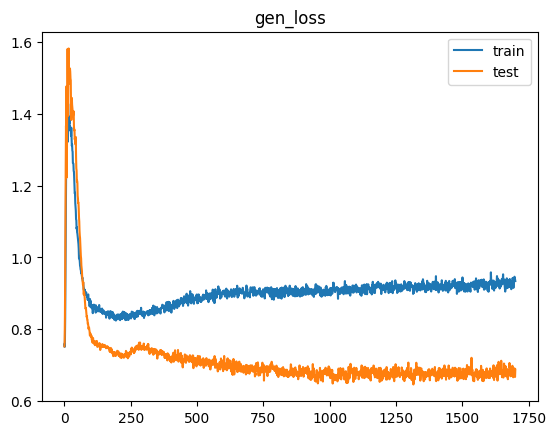

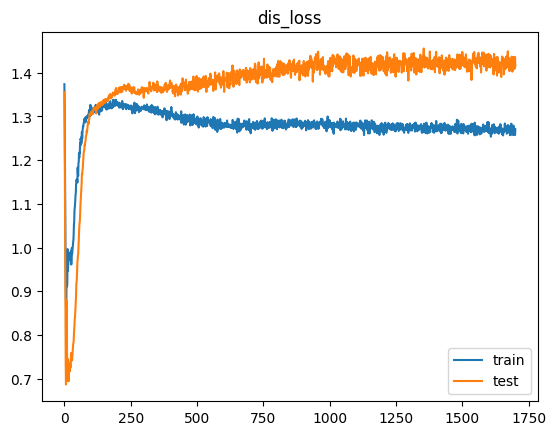

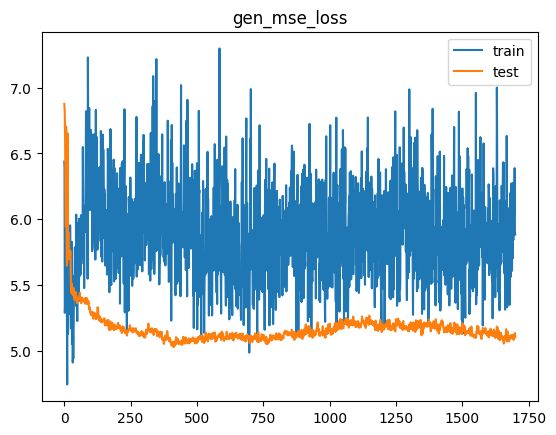

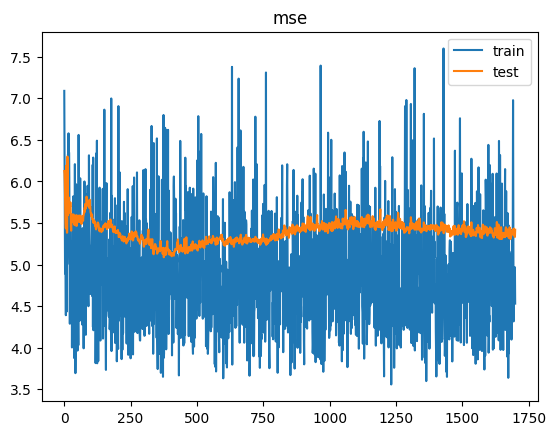

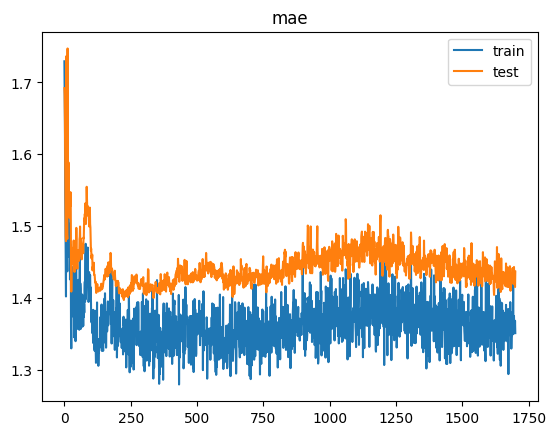

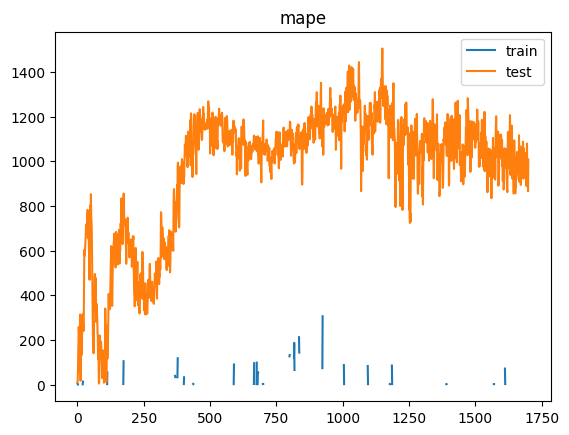

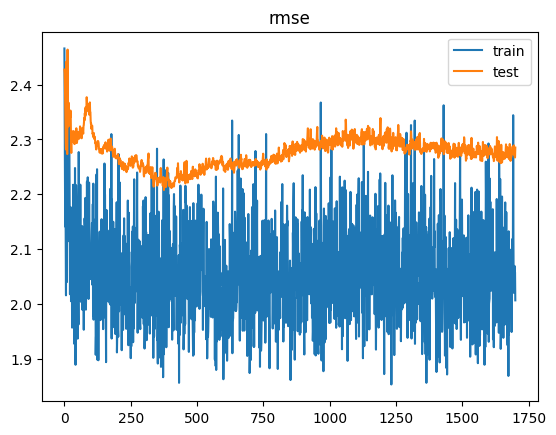

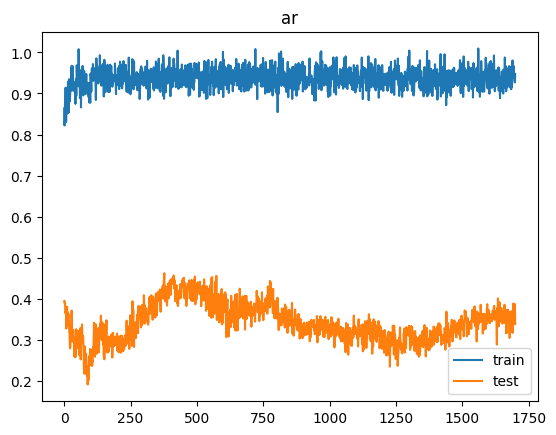

2/2 [==============================] - 0s 6ms/step


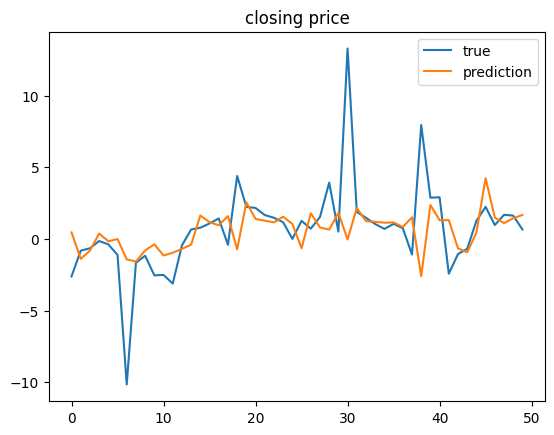

[MSE Baseline] train: 4.312659670586261  test: 5.023830941163814
Delta time with epochs = 1700: 0:40:19.787506
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_14 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_14 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_15 (GRU) 

Time for epoch 53 is 1.5693390369415283 sec Generator Loss: 0.9964926242828369,  Discriminator_loss: 1.1826598644256592
Time for epoch 54 is 1.5642578601837158 sec Generator Loss: 0.9934855103492737,  Discriminator_loss: 1.184732437133789
Time for epoch 55 is 1.4538359642028809 sec Generator Loss: 0.9929376840591431,  Discriminator_loss: 1.1860920190811157
Time for epoch 56 is 1.5280787944793701 sec Generator Loss: 0.986189603805542,  Discriminator_loss: 1.1935579776763916
Time for epoch 57 is 1.5331981182098389 sec Generator Loss: 0.9903419613838196,  Discriminator_loss: 1.1839876174926758
Time for epoch 58 is 1.482266902923584 sec Generator Loss: 0.9815049767494202,  Discriminator_loss: 1.1996374130249023
Time for epoch 59 is 1.5498998165130615 sec Generator Loss: 0.9902681708335876,  Discriminator_loss: 1.1928930282592773
Time for epoch 60 is 1.6173057556152344 sec Generator Loss: 0.980908989906311,  Discriminator_loss: 1.2058602571487427
Time for epoch 61 is 1.5549938678741455 sec 

Time for epoch 122 is 1.3208632469177246 sec Generator Loss: 0.8827640414237976,  Discriminator_loss: 1.2880651950836182
Time for epoch 123 is 1.4252851009368896 sec Generator Loss: 0.8689048290252686,  Discriminator_loss: 1.304572343826294
Time for epoch 124 is 1.4588978290557861 sec Generator Loss: 0.8660663366317749,  Discriminator_loss: 1.291610836982727
Time for epoch 125 is 1.4661474227905273 sec Generator Loss: 0.871494710445404,  Discriminator_loss: 1.287097692489624
Time for epoch 126 is 1.4419047832489014 sec Generator Loss: 0.8944224119186401,  Discriminator_loss: 1.282806158065796
Time for epoch 127 is 1.4912853240966797 sec Generator Loss: 0.882344663143158,  Discriminator_loss: 1.2881141901016235
Time for epoch 128 is 1.4103891849517822 sec Generator Loss: 0.869223415851593,  Discriminator_loss: 1.2848864793777466
Time for epoch 129 is 1.3743789196014404 sec Generator Loss: 0.8711851835250854,  Discriminator_loss: 1.2971365451812744
Time for epoch 130 is 1.442131996154785

Time for epoch 191 is 1.4005787372589111 sec Generator Loss: 0.8786887526512146,  Discriminator_loss: 1.294897437095642
Time for epoch 192 is 1.3970303535461426 sec Generator Loss: 0.878828227519989,  Discriminator_loss: 1.2853895425796509
Time for epoch 193 is 1.5498161315917969 sec Generator Loss: 0.8834978938102722,  Discriminator_loss: 1.288212537765503
Time for epoch 194 is 1.7247576713562012 sec Generator Loss: 0.8752075433731079,  Discriminator_loss: 1.29751718044281
Time for epoch 195 is 1.8882412910461426 sec Generator Loss: 0.8742810487747192,  Discriminator_loss: 1.3046427965164185
Time for epoch 196 is 1.8626389503479004 sec Generator Loss: 0.8774195313453674,  Discriminator_loss: 1.2934931516647339
Time for epoch 197 is 1.9048213958740234 sec Generator Loss: 0.8668349981307983,  Discriminator_loss: 1.301474690437317
Time for epoch 198 is 1.6672313213348389 sec Generator Loss: 0.8720859885215759,  Discriminator_loss: 1.2996982336044312
Time for epoch 199 is 1.48399734497070

Time for epoch 259 is 1.514984369277954 sec Generator Loss: 0.8701353073120117,  Discriminator_loss: 1.2957029342651367
Time for epoch 260 is 1.46484375 sec Generator Loss: 0.8683286905288696,  Discriminator_loss: 1.302437424659729
Time for epoch 261 is 1.4395766258239746 sec Generator Loss: 0.8748907446861267,  Discriminator_loss: 1.2956291437149048
Time for epoch 262 is 1.54827880859375 sec Generator Loss: 0.8718811273574829,  Discriminator_loss: 1.2955154180526733
Time for epoch 263 is 1.4976811408996582 sec Generator Loss: 0.863335907459259,  Discriminator_loss: 1.3104804754257202
Time for epoch 264 is 1.4877738952636719 sec Generator Loss: 0.8680980205535889,  Discriminator_loss: 1.2963347434997559
Time for epoch 265 is 1.5384128093719482 sec Generator Loss: 0.8839911818504333,  Discriminator_loss: 1.290653109550476
Time for epoch 266 is 1.424870252609253 sec Generator Loss: 0.8625930547714233,  Discriminator_loss: 1.2926396131515503
Time for epoch 267 is 1.4110667705535889 sec Ge

Time for epoch 328 is 1.7803070545196533 sec Generator Loss: 0.852790892124176,  Discriminator_loss: 1.3122892379760742
Time for epoch 329 is 1.648486614227295 sec Generator Loss: 0.8661401867866516,  Discriminator_loss: 1.2961336374282837
Time for epoch 330 is 1.8391168117523193 sec Generator Loss: 0.8671784996986389,  Discriminator_loss: 1.300519585609436
Time for epoch 331 is 1.5934312343597412 sec Generator Loss: 0.8601605892181396,  Discriminator_loss: 1.2975460290908813
Time for epoch 332 is 1.8342394828796387 sec Generator Loss: 0.8699332475662231,  Discriminator_loss: 1.3032370805740356
Time for epoch 333 is 1.9874494075775146 sec Generator Loss: 0.8623669743537903,  Discriminator_loss: 1.3183406591415405
Time for epoch 334 is 1.840956211090088 sec Generator Loss: 0.8650332689285278,  Discriminator_loss: 1.3066744804382324
Time for epoch 335 is 2.038062572479248 sec Generator Loss: 0.8603124618530273,  Discriminator_loss: 1.3077044486999512
Time for epoch 336 is 1.8174226284027

Time for epoch 397 is 1.3755738735198975 sec Generator Loss: 0.8580342531204224,  Discriminator_loss: 1.3047884702682495
Time for epoch 398 is 1.4986026287078857 sec Generator Loss: 0.863335371017456,  Discriminator_loss: 1.3079644441604614
Time for epoch 399 is 1.443321704864502 sec Generator Loss: 0.8643316030502319,  Discriminator_loss: 1.3091421127319336
Time for epoch 400 is 1.4272615909576416 sec Generator Loss: 0.8652492761611938,  Discriminator_loss: 1.3066617250442505
Time for epoch 401 is 1.472731590270996 sec Generator Loss: 0.8721469640731812,  Discriminator_loss: 1.2995468378067017
Time for epoch 402 is 1.4679911136627197 sec Generator Loss: 0.8634464144706726,  Discriminator_loss: 1.3060654401779175
Time for epoch 403 is 1.4080348014831543 sec Generator Loss: 0.8716903924942017,  Discriminator_loss: 1.3067868947982788
Time for epoch 404 is 1.422985553741455 sec Generator Loss: 0.8674046397209167,  Discriminator_loss: 1.3011627197265625
Time for epoch 405 is 1.733683109283

Time for epoch 466 is 1.4886229038238525 sec Generator Loss: 0.8708523511886597,  Discriminator_loss: 1.293260931968689
Time for epoch 467 is 1.4644520282745361 sec Generator Loss: 0.8664648532867432,  Discriminator_loss: 1.2962545156478882
Time for epoch 468 is 1.4648888111114502 sec Generator Loss: 0.8711649775505066,  Discriminator_loss: 1.3024369478225708
Time for epoch 469 is 1.4288127422332764 sec Generator Loss: 0.8633132576942444,  Discriminator_loss: 1.3045237064361572
Time for epoch 470 is 1.4455320835113525 sec Generator Loss: 0.864672064781189,  Discriminator_loss: 1.3101197481155396
Time for epoch 471 is 1.4338185787200928 sec Generator Loss: 0.871594250202179,  Discriminator_loss: 1.3087769746780396
Time for epoch 472 is 1.4563205242156982 sec Generator Loss: 0.8682045340538025,  Discriminator_loss: 1.3047306537628174
Time for epoch 473 is 1.3885481357574463 sec Generator Loss: 0.8780310153961182,  Discriminator_loss: 1.2969768047332764
Time for epoch 474 is 1.44409942626

Time for epoch 535 is 1.5573759078979492 sec Generator Loss: 0.8615429997444153,  Discriminator_loss: 1.312364101409912
Time for epoch 536 is 1.5657777786254883 sec Generator Loss: 0.8820831179618835,  Discriminator_loss: 1.2942779064178467
Time for epoch 537 is 1.5045907497406006 sec Generator Loss: 0.8771277666091919,  Discriminator_loss: 1.3008899688720703
Time for epoch 538 is 1.5225834846496582 sec Generator Loss: 0.8727002143859863,  Discriminator_loss: 1.3057869672775269
Time for epoch 539 is 1.6006982326507568 sec Generator Loss: 0.8729618191719055,  Discriminator_loss: 1.2988451719284058
Time for epoch 540 is 1.5374045372009277 sec Generator Loss: 0.8728187680244446,  Discriminator_loss: 1.3040282726287842
Time for epoch 541 is 1.5021731853485107 sec Generator Loss: 0.8645120859146118,  Discriminator_loss: 1.3018534183502197
Time for epoch 542 is 1.485713243484497 sec Generator Loss: 0.8742968440055847,  Discriminator_loss: 1.301796793937683
Time for epoch 543 is 1.46885895729

Time for epoch 604 is 1.402273416519165 sec Generator Loss: 0.8690654635429382,  Discriminator_loss: 1.306323528289795
Time for epoch 605 is 1.4398515224456787 sec Generator Loss: 0.8792709112167358,  Discriminator_loss: 1.2994107007980347
Time for epoch 606 is 1.3979072570800781 sec Generator Loss: 0.8704819679260254,  Discriminator_loss: 1.3065390586853027
Time for epoch 607 is 1.4812474250793457 sec Generator Loss: 0.8765406608581543,  Discriminator_loss: 1.3078453540802002
Time for epoch 608 is 1.4562559127807617 sec Generator Loss: 0.8752073049545288,  Discriminator_loss: 1.302547574043274
Time for epoch 609 is 1.482656478881836 sec Generator Loss: 0.8697205185890198,  Discriminator_loss: 1.2961654663085938
Time for epoch 610 is 1.5577220916748047 sec Generator Loss: 0.869463324546814,  Discriminator_loss: 1.3061405420303345
Time for epoch 611 is 1.4515037536621094 sec Generator Loss: 0.8778071999549866,  Discriminator_loss: 1.3042148351669312
Time for epoch 612 is 1.5067658424377

Time for epoch 672 is 1.4582066535949707 sec Generator Loss: 0.8828093409538269,  Discriminator_loss: 1.307782769203186
Time for epoch 673 is 1.4425201416015625 sec Generator Loss: 0.8844847679138184,  Discriminator_loss: 1.2976329326629639
Time for epoch 674 is 1.4387292861938477 sec Generator Loss: 0.8893964886665344,  Discriminator_loss: 1.3028488159179688
Time for epoch 675 is 1.4338946342468262 sec Generator Loss: 0.8871932625770569,  Discriminator_loss: 1.2875903844833374
Time for epoch 676 is 1.4865641593933105 sec Generator Loss: 0.8781153559684753,  Discriminator_loss: 1.3035475015640259
Time for epoch 677 is 1.4638900756835938 sec Generator Loss: 0.8878081440925598,  Discriminator_loss: 1.2941545248031616
Time for epoch 678 is 1.4370396137237549 sec Generator Loss: 0.8786464333534241,  Discriminator_loss: 1.3036439418792725
Time for epoch 679 is 1.4813947677612305 sec Generator Loss: 0.8748934864997864,  Discriminator_loss: 1.3120311498641968
Time for epoch 680 is 1.509124517

Time for epoch 740 is 1.5517675876617432 sec Generator Loss: 0.8864789605140686,  Discriminator_loss: 1.299843192100525
Time for epoch 741 is 1.464594841003418 sec Generator Loss: 0.892004668712616,  Discriminator_loss: 1.2996598482131958
Time for epoch 742 is 1.4761638641357422 sec Generator Loss: 0.8786123394966125,  Discriminator_loss: 1.3019756078720093
Time for epoch 743 is 1.5220446586608887 sec Generator Loss: 0.8869578242301941,  Discriminator_loss: 1.2826917171478271
Time for epoch 744 is 1.3978204727172852 sec Generator Loss: 0.8918043971061707,  Discriminator_loss: 1.291907548904419
Time for epoch 745 is 1.4932258129119873 sec Generator Loss: 0.8884477615356445,  Discriminator_loss: 1.2897030115127563
Time for epoch 746 is 1.4528064727783203 sec Generator Loss: 0.8928633332252502,  Discriminator_loss: 1.2835012674331665
Time for epoch 747 is 1.4844591617584229 sec Generator Loss: 0.8784872889518738,  Discriminator_loss: 1.3041468858718872
Time for epoch 748 is 1.494702339172

Time for epoch 809 is 1.636641263961792 sec Generator Loss: 0.8938303589820862,  Discriminator_loss: 1.2978965044021606
Time for epoch 810 is 1.669895887374878 sec Generator Loss: 0.8979105353355408,  Discriminator_loss: 1.283082365989685
Time for epoch 811 is 1.5171175003051758 sec Generator Loss: 0.8906677961349487,  Discriminator_loss: 1.295624017715454
Time for epoch 812 is 1.5059034824371338 sec Generator Loss: 0.8921396732330322,  Discriminator_loss: 1.2894165515899658
Time for epoch 813 is 1.5928428173065186 sec Generator Loss: 0.8851535320281982,  Discriminator_loss: 1.290507435798645
Time for epoch 814 is 1.5340161323547363 sec Generator Loss: 0.8904405832290649,  Discriminator_loss: 1.2976335287094116
Time for epoch 815 is 1.584911584854126 sec Generator Loss: 0.8918760418891907,  Discriminator_loss: 1.2961320877075195
Time for epoch 816 is 1.6275839805603027 sec Generator Loss: 0.8840382099151611,  Discriminator_loss: 1.291498064994812
Time for epoch 817 is 1.519657611846923

Time for epoch 878 is 1.477431058883667 sec Generator Loss: 0.8851629495620728,  Discriminator_loss: 1.2962348461151123
Time for epoch 879 is 1.4298677444458008 sec Generator Loss: 0.9026666879653931,  Discriminator_loss: 1.2843595743179321
Time for epoch 880 is 1.5508482456207275 sec Generator Loss: 0.8889034390449524,  Discriminator_loss: 1.2930850982666016
Time for epoch 881 is 1.4025204181671143 sec Generator Loss: 0.8864452242851257,  Discriminator_loss: 1.2957168817520142
Time for epoch 882 is 1.487764596939087 sec Generator Loss: 0.8924486637115479,  Discriminator_loss: 1.2927260398864746
Time for epoch 883 is 1.5207386016845703 sec Generator Loss: 0.8901596069335938,  Discriminator_loss: 1.2991936206817627
Time for epoch 884 is 1.6211655139923096 sec Generator Loss: 0.8893148899078369,  Discriminator_loss: 1.2957361936569214
Time for epoch 885 is 1.9492690563201904 sec Generator Loss: 0.8854302167892456,  Discriminator_loss: 1.2997971773147583
Time for epoch 886 is 2.1080853939

Time for epoch 947 is 1.555051326751709 sec Generator Loss: 0.8915607333183289,  Discriminator_loss: 1.2933212518692017
Time for epoch 948 is 1.5683887004852295 sec Generator Loss: 0.8898482322692871,  Discriminator_loss: 1.2931554317474365
Time for epoch 949 is 1.8205976486206055 sec Generator Loss: 0.892471194267273,  Discriminator_loss: 1.2899669408798218
Time for epoch 950 is 1.5980675220489502 sec Generator Loss: 0.9016854763031006,  Discriminator_loss: 1.2893015146255493
Time for epoch 951 is 2.014824151992798 sec Generator Loss: 0.9000892043113708,  Discriminator_loss: 1.2820554971694946
Time for epoch 952 is 1.9515700340270996 sec Generator Loss: 0.8932133913040161,  Discriminator_loss: 1.2886244058609009
Time for epoch 953 is 1.884347915649414 sec Generator Loss: 0.8982639908790588,  Discriminator_loss: 1.2833175659179688
Time for epoch 954 is 1.9161739349365234 sec Generator Loss: 0.8975260257720947,  Discriminator_loss: 1.30011785030365
Time for epoch 955 is 1.82309079170227

Time for epoch 1016 is 1.9280385971069336 sec Generator Loss: 0.9130738973617554,  Discriminator_loss: 1.2823541164398193
Time for epoch 1017 is 1.7397902011871338 sec Generator Loss: 0.8926336765289307,  Discriminator_loss: 1.2871983051300049
Time for epoch 1018 is 1.9877855777740479 sec Generator Loss: 0.8997538089752197,  Discriminator_loss: 1.2880131006240845
Time for epoch 1019 is 1.7658119201660156 sec Generator Loss: 0.9171943068504333,  Discriminator_loss: 1.2777107954025269
Time for epoch 1020 is 1.669262409210205 sec Generator Loss: 0.9036350846290588,  Discriminator_loss: 1.2928022146224976
Time for epoch 1021 is 1.6250791549682617 sec Generator Loss: 0.9105976819992065,  Discriminator_loss: 1.2840139865875244
Time for epoch 1022 is 1.8205246925354004 sec Generator Loss: 0.8970170021057129,  Discriminator_loss: 1.296406865119934
Time for epoch 1023 is 1.7109489440917969 sec Generator Loss: 0.898549497127533,  Discriminator_loss: 1.2981562614440918
Time for epoch 1024 is 1.72

Time for epoch 1084 is 1.4258055686950684 sec Generator Loss: 0.8908042311668396,  Discriminator_loss: 1.2942984104156494
Time for epoch 1085 is 1.3542742729187012 sec Generator Loss: 0.8954055309295654,  Discriminator_loss: 1.290593147277832
Time for epoch 1086 is 1.3723070621490479 sec Generator Loss: 0.8881829380989075,  Discriminator_loss: 1.2948583364486694
Time for epoch 1087 is 1.3605892658233643 sec Generator Loss: 0.9045642018318176,  Discriminator_loss: 1.2905141115188599
Time for epoch 1088 is 1.3474199771881104 sec Generator Loss: 0.8865029811859131,  Discriminator_loss: 1.2984031438827515
Time for epoch 1089 is 1.3624804019927979 sec Generator Loss: 0.891301691532135,  Discriminator_loss: 1.2911250591278076
Time for epoch 1090 is 1.325249433517456 sec Generator Loss: 0.8911394476890564,  Discriminator_loss: 1.2962623834609985
Time for epoch 1091 is 1.3925399780273438 sec Generator Loss: 0.9030306339263916,  Discriminator_loss: 1.2769771814346313
Time for epoch 1092 is 1.37

Time for epoch 1152 is 1.3642094135284424 sec Generator Loss: 0.8889528512954712,  Discriminator_loss: 1.2986286878585815
Time for epoch 1153 is 1.43745756149292 sec Generator Loss: 0.8765401244163513,  Discriminator_loss: 1.3026388883590698
Time for epoch 1154 is 1.3790638446807861 sec Generator Loss: 0.8930299878120422,  Discriminator_loss: 1.2867730855941772
Time for epoch 1155 is 1.359997272491455 sec Generator Loss: 0.8948642015457153,  Discriminator_loss: 1.2917898893356323
Time for epoch 1156 is 1.3467936515808105 sec Generator Loss: 0.8978440761566162,  Discriminator_loss: 1.2949429750442505
Time for epoch 1157 is 1.3849420547485352 sec Generator Loss: 0.8848706483840942,  Discriminator_loss: 1.2926898002624512
Time for epoch 1158 is 1.3981575965881348 sec Generator Loss: 0.9059343338012695,  Discriminator_loss: 1.2955201864242554
Time for epoch 1159 is 1.3719513416290283 sec Generator Loss: 0.8863462209701538,  Discriminator_loss: 1.2974045276641846
Time for epoch 1160 is 1.38

Time for epoch 1220 is 1.3984460830688477 sec Generator Loss: 0.892837405204773,  Discriminator_loss: 1.2941288948059082
Time for epoch 1221 is 1.377742052078247 sec Generator Loss: 0.9130443930625916,  Discriminator_loss: 1.2768943309783936
Time for epoch 1222 is 1.7811951637268066 sec Generator Loss: 0.9020582437515259,  Discriminator_loss: 1.285727620124817
Time for epoch 1223 is 1.4886448383331299 sec Generator Loss: 0.9061387777328491,  Discriminator_loss: 1.287814974784851
Time for epoch 1224 is 1.5032598972320557 sec Generator Loss: 0.8990440964698792,  Discriminator_loss: 1.2912384271621704
Time for epoch 1225 is 1.6220574378967285 sec Generator Loss: 0.8962253332138062,  Discriminator_loss: 1.290554165840149
Time for epoch 1226 is 1.5509588718414307 sec Generator Loss: 0.9167581796646118,  Discriminator_loss: 1.2710431814193726
Time for epoch 1227 is 1.5121057033538818 sec Generator Loss: 0.9045913815498352,  Discriminator_loss: 1.2944674491882324
Time for epoch 1228 is 1.5136

Time for epoch 1288 is 1.69832444190979 sec Generator Loss: 0.8994513750076294,  Discriminator_loss: 1.2897666692733765
Time for epoch 1289 is 1.6724860668182373 sec Generator Loss: 0.9008498191833496,  Discriminator_loss: 1.2891613245010376
Time for epoch 1290 is 1.7009642124176025 sec Generator Loss: 0.9044920802116394,  Discriminator_loss: 1.2886555194854736
Time for epoch 1291 is 1.6805598735809326 sec Generator Loss: 0.9068076014518738,  Discriminator_loss: 1.2928353548049927
Time for epoch 1292 is 1.678393840789795 sec Generator Loss: 0.8906968235969543,  Discriminator_loss: 1.2931472063064575
Time for epoch 1293 is 1.4743304252624512 sec Generator Loss: 0.890444278717041,  Discriminator_loss: 1.2908672094345093
Time for epoch 1294 is 1.427119255065918 sec Generator Loss: 0.8859741687774658,  Discriminator_loss: 1.3010663986206055
Time for epoch 1295 is 1.4754810333251953 sec Generator Loss: 0.8948719501495361,  Discriminator_loss: 1.2923046350479126
Time for epoch 1296 is 1.5062

Time for epoch 1356 is 1.6917238235473633 sec Generator Loss: 0.9182583689689636,  Discriminator_loss: 1.2883126735687256
Time for epoch 1357 is 1.6133170127868652 sec Generator Loss: 0.9185788631439209,  Discriminator_loss: 1.2863149642944336
Time for epoch 1358 is 1.7428483963012695 sec Generator Loss: 0.8959141969680786,  Discriminator_loss: 1.2845009565353394
Time for epoch 1359 is 1.7126071453094482 sec Generator Loss: 0.8938004374504089,  Discriminator_loss: 1.2959942817687988
Time for epoch 1360 is 1.676579475402832 sec Generator Loss: 0.8896375894546509,  Discriminator_loss: 1.2931627035140991
Time for epoch 1361 is 1.5033495426177979 sec Generator Loss: 0.9053897857666016,  Discriminator_loss: 1.2778019905090332
Time for epoch 1362 is 1.5889503955841064 sec Generator Loss: 0.9081222414970398,  Discriminator_loss: 1.2970175743103027
Time for epoch 1363 is 1.7295491695404053 sec Generator Loss: 0.9018457531929016,  Discriminator_loss: 1.2912497520446777
Time for epoch 1364 is 1.

Time for epoch 1424 is 1.5082173347473145 sec Generator Loss: 0.8989854454994202,  Discriminator_loss: 1.2875036001205444
Time for epoch 1425 is 1.432377576828003 sec Generator Loss: 0.9118001461029053,  Discriminator_loss: 1.282952904701233
Time for epoch 1426 is 1.4781875610351562 sec Generator Loss: 0.8934583067893982,  Discriminator_loss: 1.2910311222076416
Time for epoch 1427 is 1.4853601455688477 sec Generator Loss: 0.9008178114891052,  Discriminator_loss: 1.289592981338501
Time for epoch 1428 is 1.5121080875396729 sec Generator Loss: 0.8962302803993225,  Discriminator_loss: 1.2942687273025513
Time for epoch 1429 is 1.3765573501586914 sec Generator Loss: 0.9060938358306885,  Discriminator_loss: 1.2802224159240723
Time for epoch 1430 is 1.408336877822876 sec Generator Loss: 0.8955118060112,  Discriminator_loss: 1.2878061532974243
Time for epoch 1431 is 1.4783878326416016 sec Generator Loss: 0.892015278339386,  Discriminator_loss: 1.2936877012252808
Time for epoch 1432 is 1.5903186

Time for epoch 1492 is 1.4565086364746094 sec Generator Loss: 0.9021146297454834,  Discriminator_loss: 1.2894020080566406
Time for epoch 1493 is 1.534543514251709 sec Generator Loss: 0.8939157128334045,  Discriminator_loss: 1.2909138202667236
Time for epoch 1494 is 1.3993945121765137 sec Generator Loss: 0.9053272604942322,  Discriminator_loss: 1.2820974588394165
Time for epoch 1495 is 1.549142599105835 sec Generator Loss: 0.8983244895935059,  Discriminator_loss: 1.2984576225280762
Time for epoch 1496 is 1.483480453491211 sec Generator Loss: 0.900056004524231,  Discriminator_loss: 1.287935495376587
Time for epoch 1497 is 1.4594640731811523 sec Generator Loss: 0.9025570154190063,  Discriminator_loss: 1.281666874885559
Time for epoch 1498 is 1.4527757167816162 sec Generator Loss: 0.889638364315033,  Discriminator_loss: 1.2965493202209473
Time for epoch 1499 is 1.502971887588501 sec Generator Loss: 0.8949564695358276,  Discriminator_loss: 1.288224697113037
Time for epoch 1500 is 1.51789760

Time for epoch 1560 is 1.5476093292236328 sec Generator Loss: 0.9052920937538147,  Discriminator_loss: 1.2862039804458618
Time for epoch 1561 is 1.4897027015686035 sec Generator Loss: 0.9024631977081299,  Discriminator_loss: 1.2907476425170898
Time for epoch 1562 is 1.5501179695129395 sec Generator Loss: 0.8912294507026672,  Discriminator_loss: 1.2985591888427734
Time for epoch 1563 is 1.6760470867156982 sec Generator Loss: 0.9017605781555176,  Discriminator_loss: 1.2908844947814941
Time for epoch 1564 is 1.5284759998321533 sec Generator Loss: 0.9030482769012451,  Discriminator_loss: 1.285328984260559
Time for epoch 1565 is 1.5550546646118164 sec Generator Loss: 0.89443439245224,  Discriminator_loss: 1.2897605895996094
Time for epoch 1566 is 1.5679373741149902 sec Generator Loss: 0.9059647917747498,  Discriminator_loss: 1.2832142114639282
Time for epoch 1567 is 1.5053558349609375 sec Generator Loss: 0.9068549871444702,  Discriminator_loss: 1.2865138053894043
Time for epoch 1568 is 1.49

Time for epoch 1628 is 1.5115382671356201 sec Generator Loss: 0.9074016809463501,  Discriminator_loss: 1.296336054801941
Time for epoch 1629 is 1.6577410697937012 sec Generator Loss: 0.8987360596656799,  Discriminator_loss: 1.3007586002349854
Time for epoch 1630 is 1.4896745681762695 sec Generator Loss: 0.8974341750144958,  Discriminator_loss: 1.2944358587265015
Time for epoch 1631 is 1.5243096351623535 sec Generator Loss: 0.896990954875946,  Discriminator_loss: 1.2958667278289795
Time for epoch 1632 is 1.5466206073760986 sec Generator Loss: 0.8805110454559326,  Discriminator_loss: 1.2917345762252808
Time for epoch 1633 is 1.668959617614746 sec Generator Loss: 0.8945786356925964,  Discriminator_loss: 1.2848072052001953
Time for epoch 1634 is 1.4737186431884766 sec Generator Loss: 0.904972493648529,  Discriminator_loss: 1.285049557685852
Time for epoch 1635 is 1.580152988433838 sec Generator Loss: 0.893071711063385,  Discriminator_loss: 1.300760269165039
Time for epoch 1636 is 1.5063591

Time for epoch 1696 is 1.398266077041626 sec Generator Loss: 0.902474045753479,  Discriminator_loss: 1.2929434776306152
Time for epoch 1697 is 1.4420537948608398 sec Generator Loss: 0.9037095308303833,  Discriminator_loss: 1.2903066873550415
Time for epoch 1698 is 1.3999669551849365 sec Generator Loss: 0.891347348690033,  Discriminator_loss: 1.2988425493240356
Time for epoch 1699 is 1.5117383003234863 sec Generator Loss: 0.884408175945282,  Discriminator_loss: 1.3064814805984497
Time for epoch 1700 is 1.4143080711364746 sec Generator Loss: 0.8958920836448669,  Discriminator_loss: 1.2929081916809082
Time for epoch 1701 is 1.4215149879455566 sec Generator Loss: 0.8975796103477478,  Discriminator_loss: 1.2924726009368896
Time for epoch 1702 is 1.4026682376861572 sec Generator Loss: 0.9056301712989807,  Discriminator_loss: 1.2873529195785522
Time for epoch 1703 is 1.453108310699463 sec Generator Loss: 0.902844250202179,  Discriminator_loss: 1.283976674079895
Time for epoch 1704 is 1.445010

Time for epoch 1764 is 1.4652292728424072 sec Generator Loss: 0.9038629531860352,  Discriminator_loss: 1.2925188541412354
Time for epoch 1765 is 1.4857397079467773 sec Generator Loss: 0.8922461271286011,  Discriminator_loss: 1.3015025854110718
Time for epoch 1766 is 1.4333980083465576 sec Generator Loss: 0.8952115178108215,  Discriminator_loss: 1.305802822113037
Time for epoch 1767 is 1.382538080215454 sec Generator Loss: 0.9191514849662781,  Discriminator_loss: 1.2842556238174438
Time for epoch 1768 is 1.516521692276001 sec Generator Loss: 0.9052988290786743,  Discriminator_loss: 1.2848131656646729
Time for epoch 1769 is 1.5066876411437988 sec Generator Loss: 0.9119659662246704,  Discriminator_loss: 1.301214575767517
Time for epoch 1770 is 1.520411729812622 sec Generator Loss: 0.8957626223564148,  Discriminator_loss: 1.2936363220214844
Time for epoch 1771 is 1.5348494052886963 sec Generator Loss: 0.8972001671791077,  Discriminator_loss: 1.2958911657333374
Time for epoch 1772 is 1.4573

Time for epoch 1832 is 1.515852928161621 sec Generator Loss: 0.8974274396896362,  Discriminator_loss: 1.2966431379318237
Time for epoch 1833 is 1.5399677753448486 sec Generator Loss: 0.8937501907348633,  Discriminator_loss: 1.287379503250122
Time for epoch 1834 is 1.5760157108306885 sec Generator Loss: 0.8948240280151367,  Discriminator_loss: 1.2912191152572632
Time for epoch 1835 is 1.487865924835205 sec Generator Loss: 0.88545823097229,  Discriminator_loss: 1.2931911945343018
Time for epoch 1836 is 1.507986307144165 sec Generator Loss: 0.9061705470085144,  Discriminator_loss: 1.2912949323654175
Time for epoch 1837 is 1.4905118942260742 sec Generator Loss: 0.9072669148445129,  Discriminator_loss: 1.2874985933303833
Time for epoch 1838 is 1.4819841384887695 sec Generator Loss: 0.9139881134033203,  Discriminator_loss: 1.290769338607788
Time for epoch 1839 is 1.5058884620666504 sec Generator Loss: 0.9005680680274963,  Discriminator_loss: 1.2930331230163574
Time for epoch 1840 is 1.453762

Time for epoch 1900 is 1.549142599105835 sec Generator Loss: 0.913216769695282,  Discriminator_loss: 1.2721776962280273
Time for epoch 1901 is 1.5231759548187256 sec Generator Loss: 0.9023464918136597,  Discriminator_loss: 1.284510612487793
Time for epoch 1902 is 1.5550079345703125 sec Generator Loss: 0.8891951441764832,  Discriminator_loss: 1.29709792137146
Time for epoch 1903 is 1.466078758239746 sec Generator Loss: 0.8974918127059937,  Discriminator_loss: 1.2926002740859985
Time for epoch 1904 is 1.5137407779693604 sec Generator Loss: 0.8921735882759094,  Discriminator_loss: 1.2934938669204712
Time for epoch 1905 is 1.4132575988769531 sec Generator Loss: 0.8973875641822815,  Discriminator_loss: 1.2921661138534546
Time for epoch 1906 is 1.4180164337158203 sec Generator Loss: 0.8920242190361023,  Discriminator_loss: 1.2867525815963745
Time for epoch 1907 is 1.4868252277374268 sec Generator Loss: 0.8937099575996399,  Discriminator_loss: 1.2905018329620361
Time for epoch 1908 is 1.44838

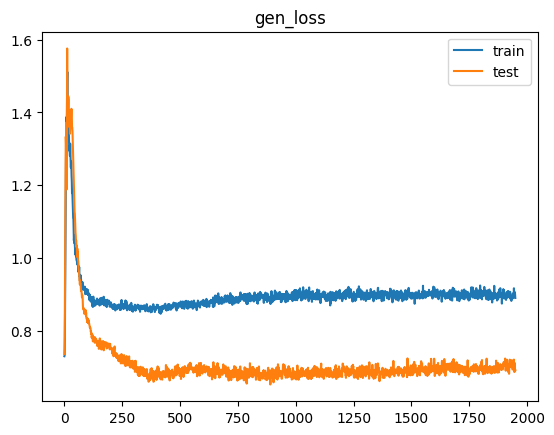

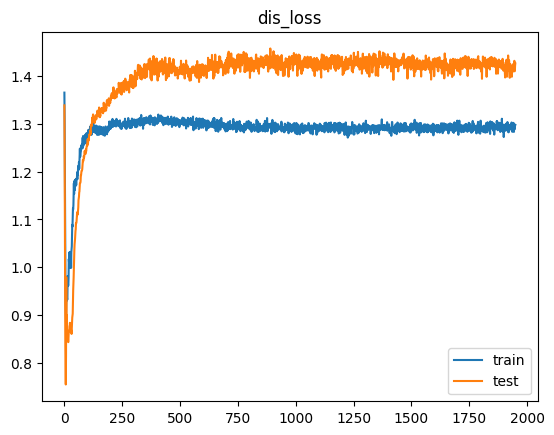

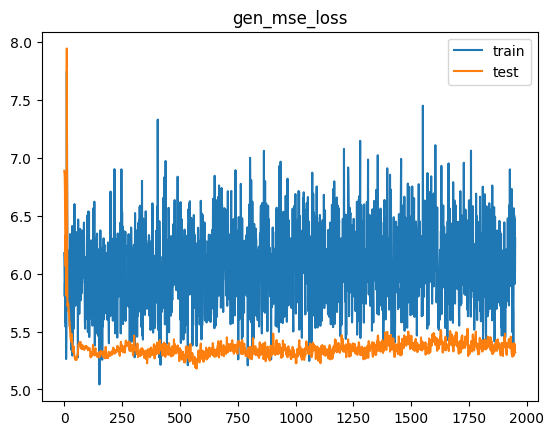

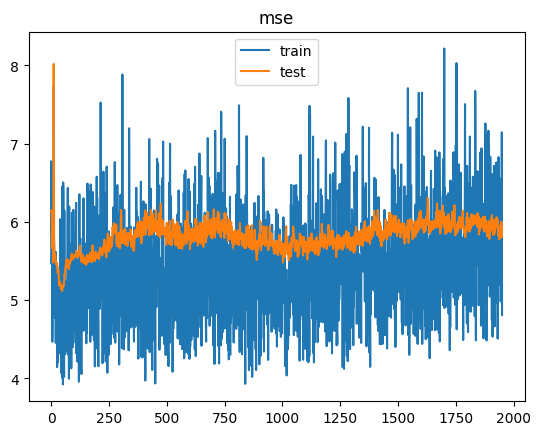

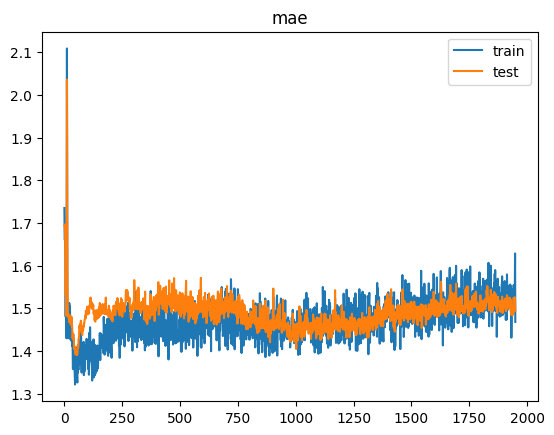

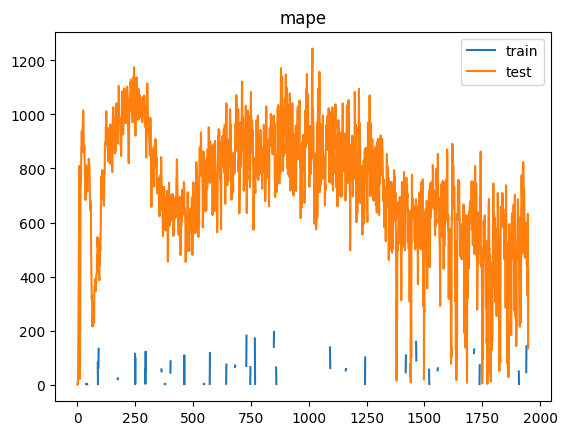

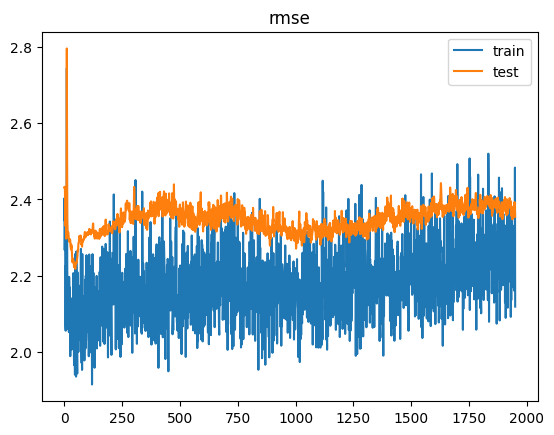

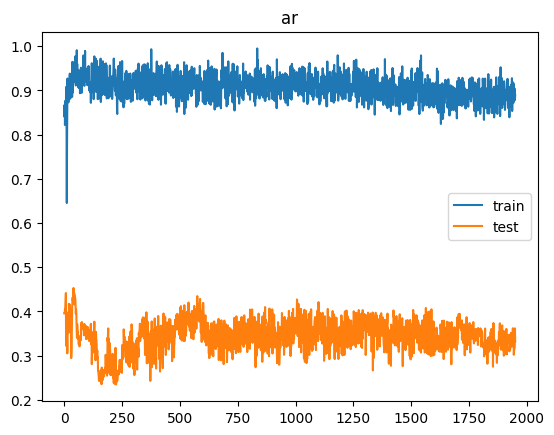

2/2 [==============================] - 0s 8ms/step


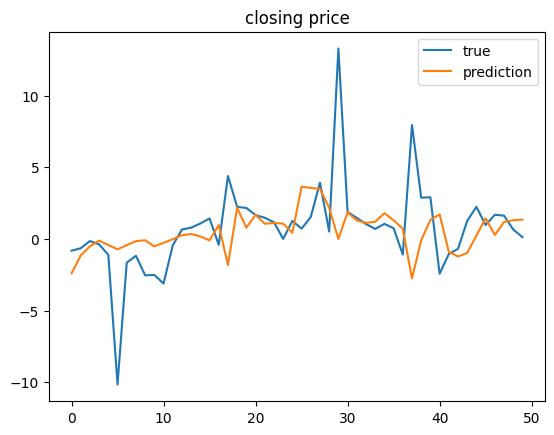

[MSE Baseline] train: 5.041391483268619  test: 5.001280720763628
Delta time with epochs = 1950: 0:50:40.950868


In [22]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))